<a href="https://colab.research.google.com/github/lbuerger/IANNwTF/blob/main/homework8/hw8_210105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time 

In [43]:
# load data and only use the 'train' part of it
load = tf.keras.datasets.fashion_mnist.load_data()
print("train images",load[0][0].shape)
print("train labels",load[0][1].shape)
print("test images",load[1][0].shape)
print("test labels",load[1][1].shape)

train images (60000, 28, 28)
train labels (60000,)
test images (10000, 28, 28)
test labels (10000,)


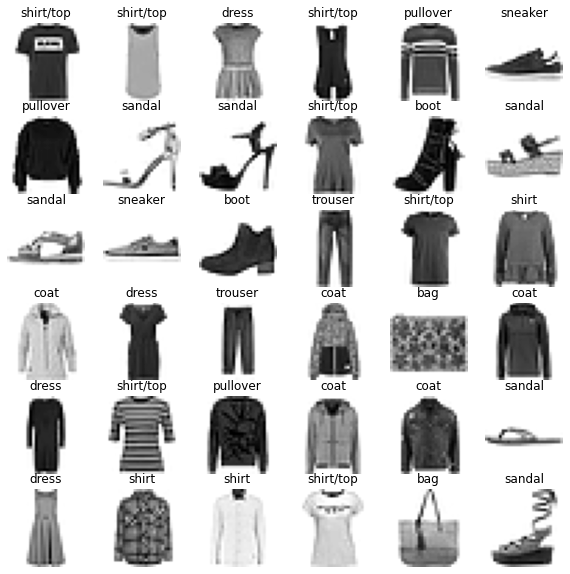

In [44]:
# plot the first entries to get an idea of the data
fig = plt.figure(figsize=(10,10))
class_names={0:'shirt/top',1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker',8:'bag', 9:'boot'}
for i in range(1,37):
  img = load[0][0][i]
  fig.add_subplot(6,6,i)
  
  plt.imshow(img, cmap="gray_r")
  plt.axis('off')  
  # the label is 0 if the image contains malaria and 1 if it does not
  plt.title( str(class_names[int(load[0][1][i])]))

fig.show()

In [45]:
def preprocess_img(image):
  """
  normalize between -1 and 1
  """
  
  max = tf.math.reduce_max(image)
  min = tf.math.reduce_min(image)
  image = ((image - min) / (max - min) -0.5) *2
  image = tf.reshape(image,image.shape + (1,))
  image = tf.image.resize(image,[32,32])
  return image

In [46]:
# Train dataset
ds_train_img = tf.data.Dataset.from_tensor_slices(load[0][0])
ds_train_img = ds_train_img.map(lambda img: preprocess_img(img))
ds_train_label = tf.data.Dataset.from_tensor_slices(load[0][1])
for entry in ds_train_label:
  print(entry)
  break;
#ds_train_label = ds_train_label.map(lambda label: tf.one_hot(label, 10))
ds_train_label = ds_train_label.map(lambda label: (1,))
for entry in ds_train_label:
  print(entry)
  break;
ds_train = tf.data.Dataset.zip((ds_train_img, ds_train_label))
#ds_train = ds_train.batch(64).shuffle(buffer_size=64)

# test dataset
"""
ds_tst_img = tf.data.Dataset.from_tensor_slices(load[1][0])
ds_tst_img = ds_tst_img.map(lambda img: preprocess_img(img))
ds_tst_label = tf.data.Dataset.from_tensor_slices(load[1][1])
ds_tst_label = ds_tst_label.map(lambda label: tf.one_hot(label, 10))
ds_tst = tf.data.Dataset.zip((ds_tst_img, ds_tst_label))
#ds_tst = ds_tst.batch(64).shuffle(buffer_size=64)
"""
print(ds_train)
#print(ds_tst)

tf.Tensor(9, shape=(), dtype=uint8)
(<tf.Tensor: shape=(), dtype=int32, numpy=1>,)
<ZipDataset shapes: ((32, 32, 1), ((),)), types: (tf.float32, (tf.int32,))>


In [47]:
for entry in ds_train:
  print(entry[1])
  break;

(<tf.Tensor: shape=(), dtype=int32, numpy=1>,)


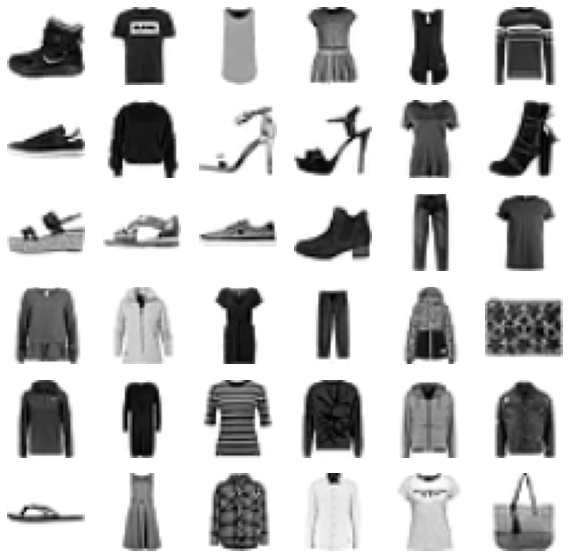

In [48]:
# re-plot the first nine entries after the mapping
def one_hot_to_int(one_hot):
  """
  reverse one hot function returning the int to the one hot vector
  """
  count = 0
  for entry in one_hot:
    if entry:
      break
    count += 1
  return count

count = 0
fig = plt.figure(figsize=(10,10))
#class_names={0:'airplane',1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse',8:'ship', 9:'truck'}
for img in ds_train:
  count += 1
  fig.add_subplot(6,6,count)
  #print(img[0].numpy()[:,:,0])
  plt.imshow(img[0][:,:,0]/2+0.5, cmap="gray_r")
  plt.axis('off')
  #plt.title(class_names[one_hot_to_int(img[1])])
  
  if count == 36:
    break;
fig.show()

In [49]:
# perf batching, shuffeling and prefetching
train_ds = ds_train.batch(32).shuffle(buffer_size=64).prefetch(4)
#test_ds = ds_tst.batch(64).shuffle(buffer_size=64).prefetch(4)

In [50]:
# to check the shape (here: 32 batch size and a 32x32 image with 3 colours)
for (img,label) in train_ds:
    print("image",img.shape)
    print("max",tf.reduce_max(img).numpy(), "min", tf.reduce_min(img).numpy(), "mean", tf.reduce_mean(img).numpy())
    #print(img[0,:,:,0])
    #print("label",label.shape)
    break;

image (32, 32, 32, 1)
max 0.99289215 min -1.0 mean -0.41738516


In [103]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers

class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    minmax = tf.keras.constraints.MinMaxNorm(min_value=-0.01,max_value=0.01)
    self.layer_list = [
      # 28x28x1
      layers.Conv2D(32, kernel_size = 3, activation = None, padding ='same', input_shape=(32,32,1), kernel_constraint=minmax),
      #layers.BatchNormalization(),
      layers.Activation(tf.nn.leaky_relu),
      #layers.MaxPool2D(pool_size=(2,2)),
      layers.Conv2D(2, kernel_size = 3, strides=2, activation = None, padding = 'same' ),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.leaky_relu),
      # 14x14xN
      layers.Conv2D(64, kernel_size = 3, activation = None, padding ='same', kernel_constraint=minmax),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.leaky_relu),
      #layers.MaxPool2D(pool_size=(2,2)),
      layers.Conv2D(4, kernel_size = 3, strides=2, activation = None, padding = 'same' ),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.leaky_relu),
      # 7x7xN 
      layers.Conv2D(128, kernel_size = 3, activation = None, padding ='same', kernel_constraint=minmax),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.leaky_relu),
      #layers.MaxPool2D(pool_size=(2,2)),
      layers.Conv2D(8, kernel_size = 3, strides=2, activation = None, padding = 'same' ),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.leaky_relu),
      # 4x4xN
      layers.Conv2D(256, kernel_size = 3, activation = None, padding ='same', kernel_constraint=minmax),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.leaky_relu),
      #layers.MaxPool2D(pool_size=(2,2)),
      layers.Conv2D(16, kernel_size = 3, strides=2, activation = None, padding = 'same' ),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.leaky_relu),
      # 2x2xN 
      layers.Conv2D(512, kernel_size = 3, strides=2, activation = None, padding ='same'),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.leaky_relu),
      # 1x1xN
      
      layers.GlobalAveragePooling2D(),
      # N
      layers.Dense(1, activation="linear")
    ]

  def call(self, x):
      for layer in self.layer_list:
        x = layer(x)
      return x

class Generator(Model):
  def __init__(self, space_size):
    super(Generator, self).__init__()
    #print("Embedding size:", shape)
    self.layer_list = [
      layers.Dense(16*256, activation="linear", input_shape=((space_size,))),
      layers.Reshape((4,4,256)),
      layers.Conv2DTranspose(128,5,strides=2,activation=None,padding='same'),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.relu),
      layers.Conv2D(64, 3, activation = None, padding ='same'),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.relu),
      layers.Conv2DTranspose(64,5,strides=2,activation=None,padding='same'),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.relu),
      layers.Conv2D(64, 3, activation = None, padding ='same'),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.relu),
      layers.Conv2DTranspose(32,5,strides=2,activation=None,padding='same'),
      layers.BatchNormalization(),
      layers.Activation(tf.nn.relu),
      layers.Conv2D(64, 3, activation = None, padding ='same'),
      #layers.BatchNormalization(),
      layers.Activation(tf.nn.relu),
      layers.Conv2D(1,kernel_size=1,activation="linear",padding="same")

    ]
  def call(self, x):
      for layer in self.layer_list:
        x = layer(x)
      return x


In [76]:
x = tf.ones((32,32,32,1))
print(x.shape)
disc = Discriminator()
y = disc(x)
print(y.shape)
gen = Generator(100)
rng = (tf.random.normal((32,100)))
print(rng.shape)
z = gen(rng)
print(z.shape)
#print(z[0,:,:,0])
#z[0,:,:,0]
#plt.imshow(z[0,:,:,0])
#print(y)


(32, 32, 32, 1)
(32, 1)
(32, 100)
(32, 32, 32, 1)


In [90]:
def random_input(batches, space_size):
  #distr = tf.random.normal((batches, space_size),stddev=1)
  #distr = tf.clip_by_value(distr,-3,3)
  distr = tf.random.uniform((batches, space_size))
  return distr

def train_generator(generator, discriminator, space_size, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    generated_images = generator(random_input(32,space_size))
    result = discriminator(generated_images)
    #loss = loss_function(tf.ones_like(result), result) #wants to fool the discriminator
    loss = -tf.math.reduce_mean(result)
    #gradients = tape.gradient(loss, generator.trainable_variables)
  #optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
  optimizer.minimize(loss,generator.trainable_variables, tape=tape)
  best_image = generated_images[tf.argmax(result)[0],:,:,0]
  acc = tf.reduce_mean(tf.clip_by_value(result,0,1))
  acc = tf.reduce_max(result)
  return loss,  best_image, acc

def train_discriminator(generator, discriminator, space_size, input, loss_function, optimizer, pre_train=False):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    generated_images = generator(random_input(32,space_size))
    #if pre_train:
    #  generated_images = - tf.ones_like(generated_images)
    #images = tf.concat([generated_images,input],0)
    #generated_batch_size = generated_images.shape[0]
    #input_batch_size = input.shape[0]
    result_fake = discriminator(generated_images)
    result_real = discriminator(input)
    #print(tf.math.reduce_mean(result_fake).numpy(), tf.math.reduce_mean(result_real).numpy()) 
    #loss = loss_function(tf.ones((input_batch_size),1),result_real) + loss_function(tf.zeros((generated_batch_size,1)),result_fake)
    loss =   tf.math.reduce_mean(result_fake) - tf.math.reduce_mean(result_real) 
    #gradients = tape.gradient(loss, discriminator.trainable_variables)
  #optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
  optimizer.minimize(loss,discriminator.trainable_variables, tape=tape)
  #acc = 1 - tf.reduce_mean(tf.clip_by_value(result_fake,0,1))
  acc = (tf.reduce_mean(result_real) - tf.reduce_mean(result_fake)) / (tf.reduce_mean(tf.abs(result_real)) + tf.reduce_mean(tf.abs(result_fake)))
  return loss, acc 
  
def train_step(generator, discriminator, space_size, input, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes  
  with tf.GradientTape(persistent=True) as tape:
    generated_images = generator(random_input(32,space_size))
    #images = tf.concat([generated_images,input],0)
    generated_batch_size = generated_images.shape[0]
    input_batch_size = input.shape[0]
    #labels = tf.concat([tf.zeros((generated_batch_size,1)),tf.ones((input_batch_size,1))],0)
    result_fake = discriminator(generated_images)
    result_real = discriminator(input)
    #print(labels, result)
    loss_gen = loss_function(tf.ones_like(result_fake), result_fake)
    loss_disc = loss_function(tf.ones((input_batch_size),1),result_real) + loss_function(tf.zeros((generated_batch_size,1)),result_fake)

  gradients_gen = tape.gradient(loss_gen, generator.trainable_variables)

  gradients_disc = tape.gradient(loss_disc, discriminator.trainable_variables)
  optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
  optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
  best_image = generated_images[tf.argmax(result_fake)[0],:,:,0]
  return loss_gen, loss_disc, best_image

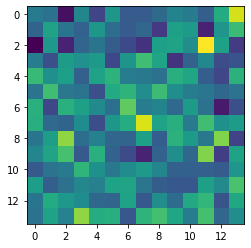

In [78]:
temp = random_input(1,196)
temp = tf.reshape(temp,[14,14])
plt.imshow(temp)
plt.show()

In [79]:
#train_step()
space_size = 10
generator = Generator(space_size)
discriminator = Discriminator()

# Using binary correntropy due to values between 0 and 1
loss_function = tf.keras.losses.BinaryCrossentropy()
# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
input = tf.ones((32,28,28,1))
# loss_object and optimizer_object are instances of respective tensorflow classes  
with tf.GradientTape(persistent=True) as tape:
  generated_images = generator(random_input(32,space_size))
  #images = tf.concat([generated_images,input],0)
  generated_batch_size = generated_images.shape[0]
  input_batch_size = input.shape[0]
  #labels = tf.concat([tf.zeros((generated_batch_size,1)),tf.ones((input_batch_size,1))],0)
  result_fake = discriminator(generated_images)
  result_real = discriminator(input)
  #print(labels, result)
  loss_gen = loss_function(tf.ones_like(result_fake), result_fake)
  loss_disc = loss_function(tf.ones((input_batch_size),1),result_real) + loss_function(tf.zeros((generated_batch_size,1)),result_fake)

gradients_gen = tape.gradient(loss_gen, generator.trainable_variables)

gradients_disc = tape.gradient(loss_disc, discriminator.trainable_variables)
optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
best_image = generated_images[tf.argmax(result_fake)[0],:,:,0]
#return loss_gen, loss_disc, best_image

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            multiple                  320       
_________________________________________________________________
activation_6 (Activation)    multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  578       
_________________________________________________________________
batch_normalization_5 (Batch multiple                  8         
_________________________________________________________________
activation_7 (Activation)    multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  1216      
_________________________________________________________________
batch_normalization_6 (Batch multiple                

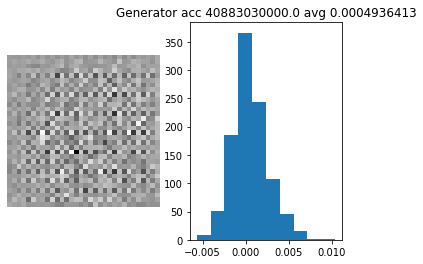

gen_acc 40883030000.0 after 81
After Epoch 0 train_loss_gen: -0.0005 train_loss_disc: 0.0 running: 8.0 sec ETA: 13.2 min
Epoch: __ 1
train_loss_disc: -0.0 disc_acc: 0.0 after 41


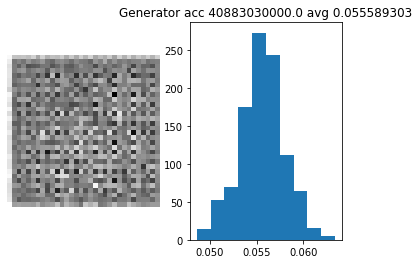

gen_acc 40883030000.0 after 161
After Epoch 1 train_loss_gen: -0.0008 train_loss_disc: -0.0 running: 18.9 sec ETA: 15.5 min
Epoch: __ 2
train_loss_disc: -6.964 disc_acc: 0.9025 after 81


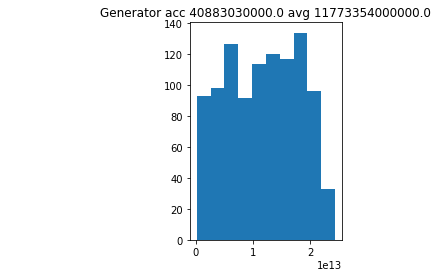

gen_acc 40883030000.0 after 321
After Epoch 2 train_loss_gen: -91664180000000.0 train_loss_disc: -6.964 running: 37.9 sec ETA: 20.4 min
Epoch: __ 3
train_loss_disc: -3398494600000000.0 disc_acc: 0.9994 after 161


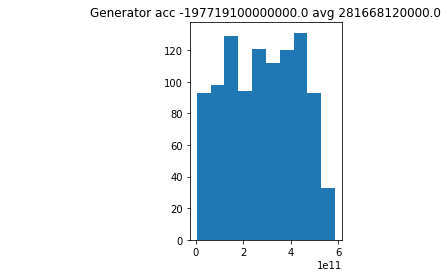

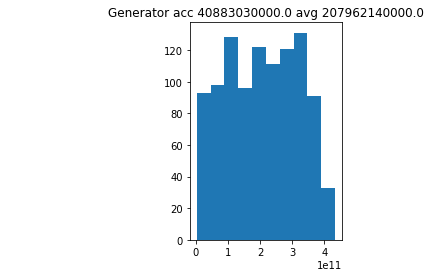

gen_acc 40883030000.0 after 641
After Epoch 3 train_loss_gen: 162094750000000.0 train_loss_disc: -3398494600000000.0 running: 70.8 sec ETA: 28.3 min
Epoch: __ 4
train_loss_disc: -728551700000000.0 disc_acc: 1.0 after 321


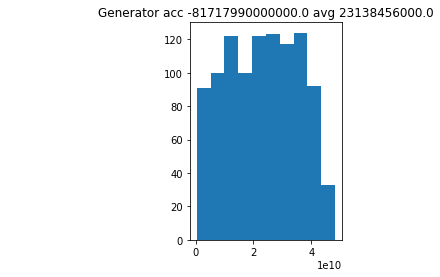

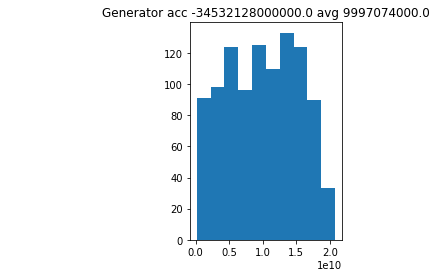

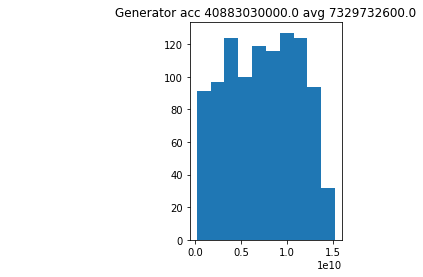

gen_acc 40883030000.0 after 1281
After Epoch 4 train_loss_gen: 28001928000000.0 train_loss_disc: -728551700000000.0 running: 130.7 sec ETA: 41.4 min
Epoch: __ 5
train_loss_disc: -33818229000000.0 disc_acc: 1.0 after 641


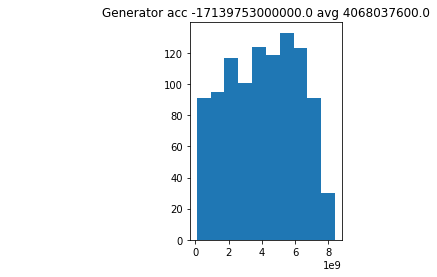

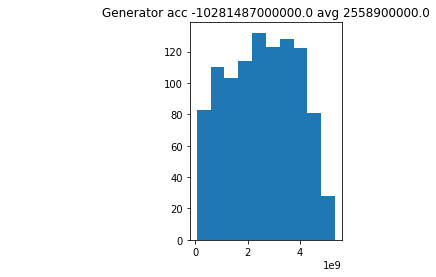

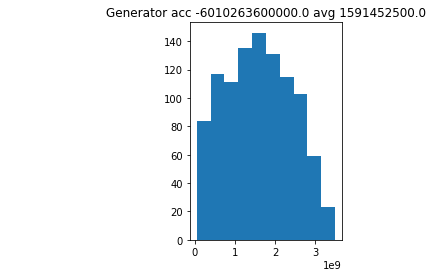

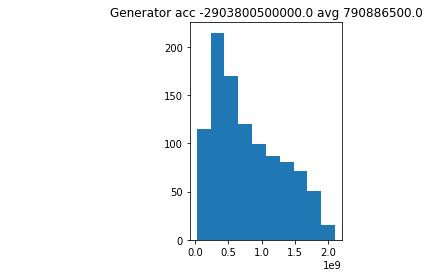

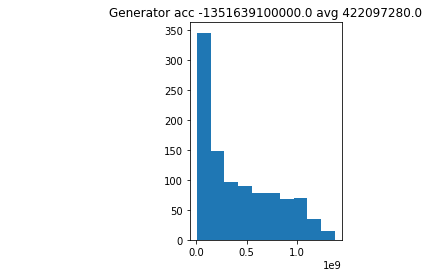

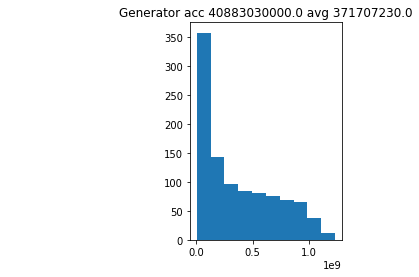

gen_acc 40883030000.0 after 2561
After Epoch 5 train_loss_gen: 1423163700000.0 train_loss_disc: -33818229000000.0 running: 244.8 sec ETA: 63.9 min
Epoch: __ 6
train_loss_disc: -1414952600000.0 disc_acc: 1.0 after 1281


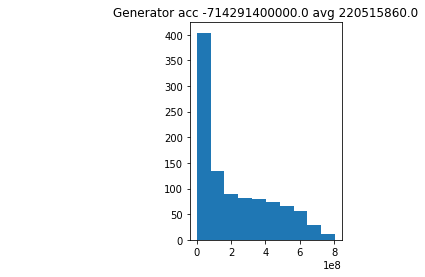

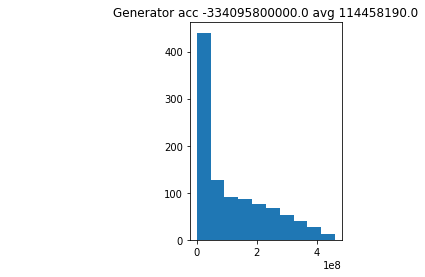

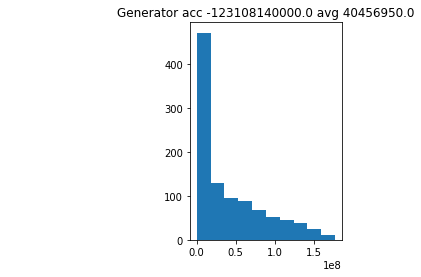

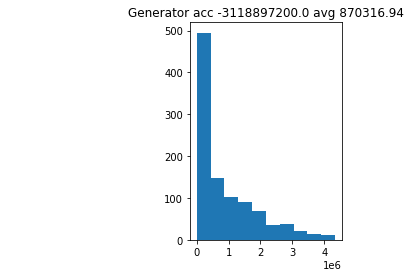

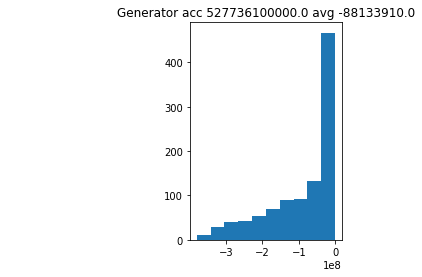

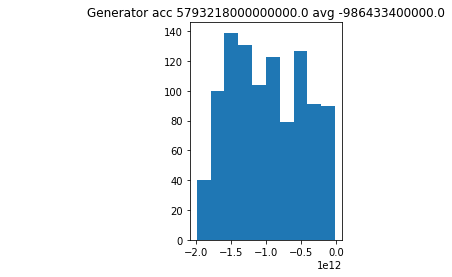

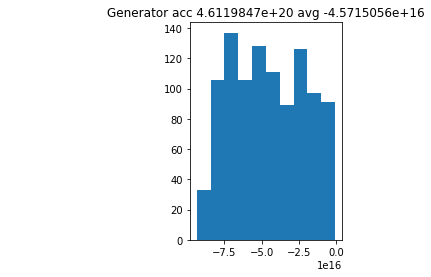

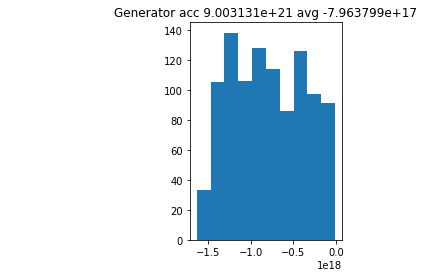

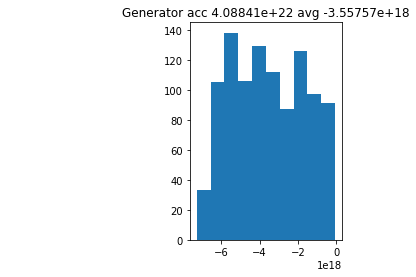

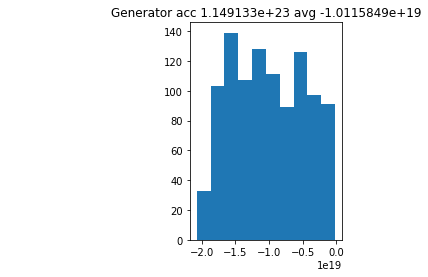

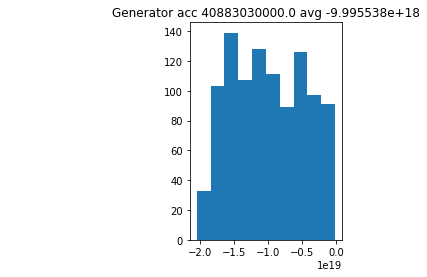

gen_acc 40883030000.0 after 5001
After Epoch 6 train_loss_gen: -1.03954735e+23 train_loss_disc: -1414952600000.0 running: 464.7 sec ETA: 102.9 min
Epoch: __ 7
train_loss_disc: 5.90572e+22 disc_acc: -1.0 after 1875


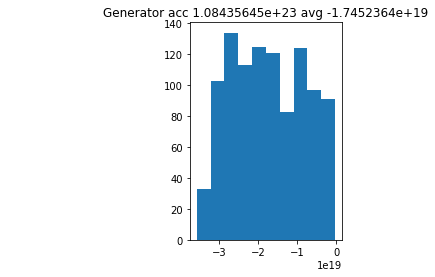

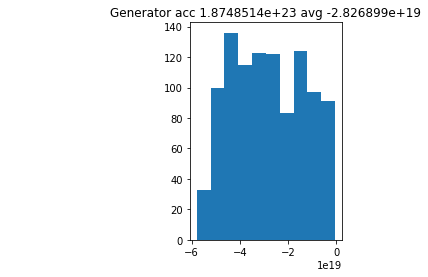

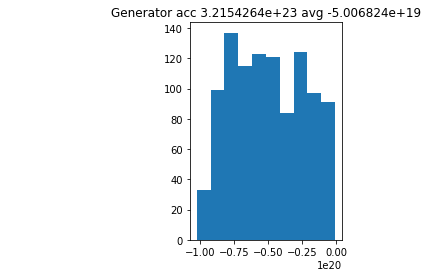

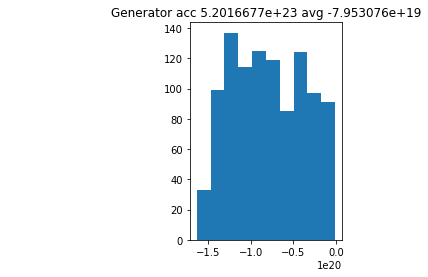

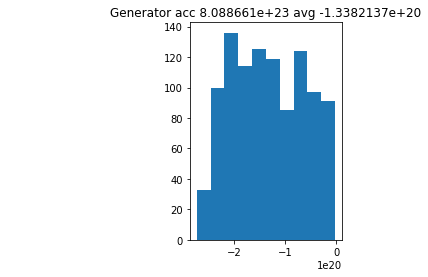

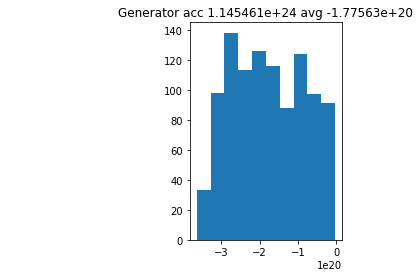

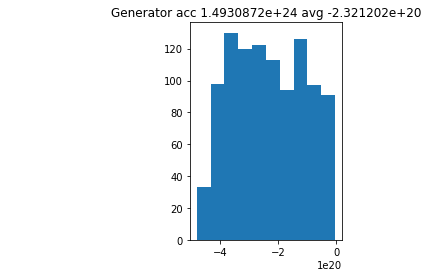

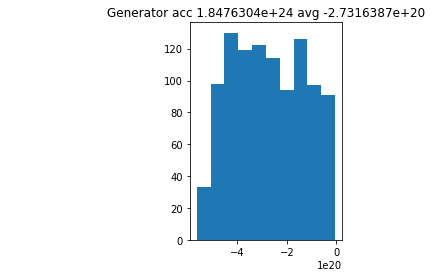

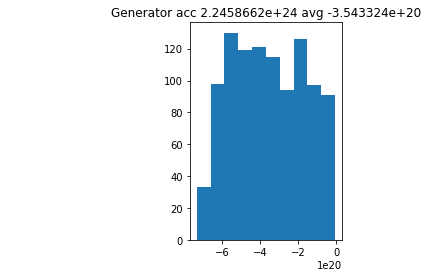

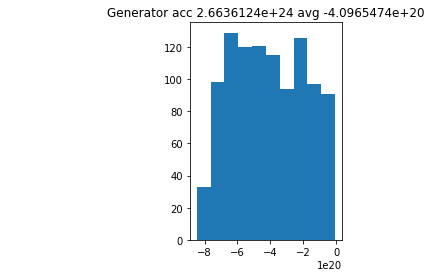

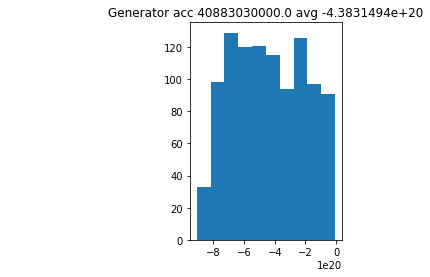

gen_acc 40883030000.0 after 5001
After Epoch 7 train_loss_gen: -2.3906645e+24 train_loss_disc: 5.90572e+22 running: 714.8 sec ETA: 137.0 min
Epoch: __ 8
train_loss_disc: 2.227396e+24 disc_acc: -1.0 after 1875


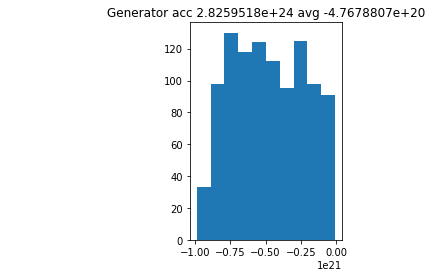

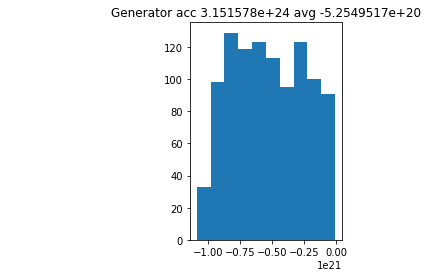

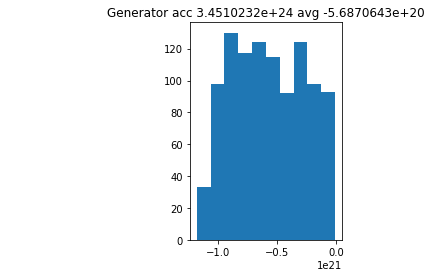

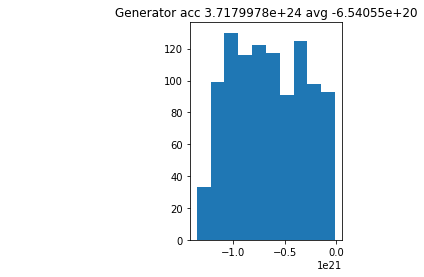

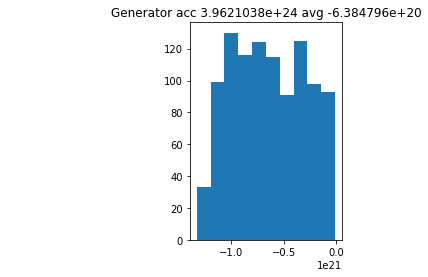

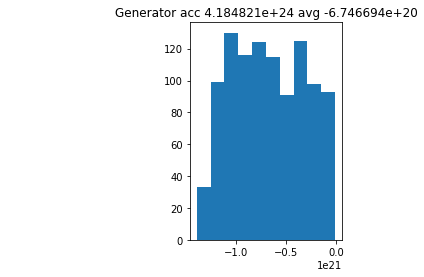

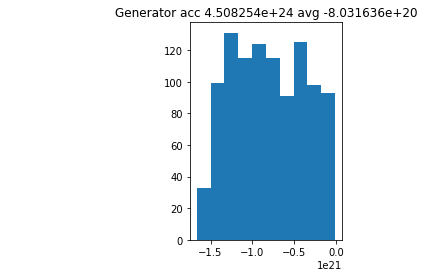

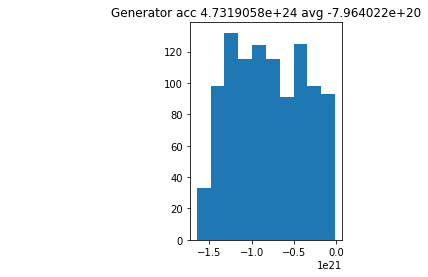

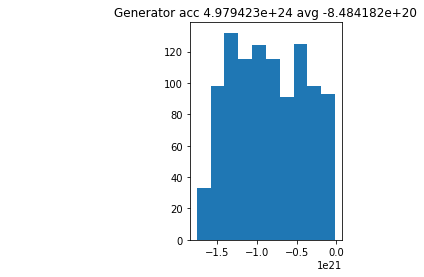

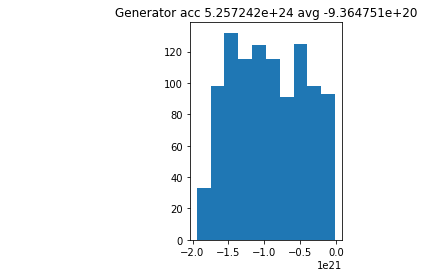

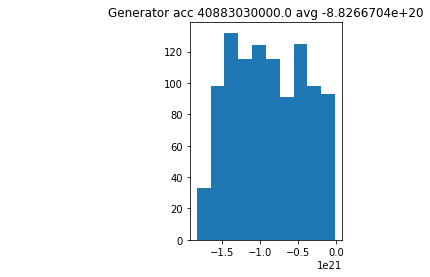

gen_acc 40883030000.0 after 5001
After Epoch 8 train_loss_gen: -4.7027417e+24 train_loss_disc: 2.227396e+24 running: 963.8 sec ETA: 162.4 min
Epoch: __ 9
train_loss_disc: 4.3679916e+24 disc_acc: -1.0 after 1875


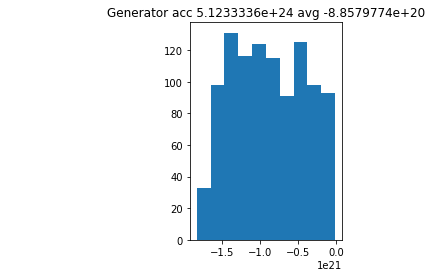

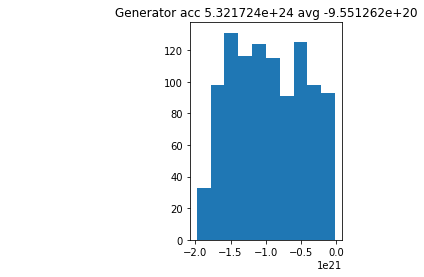

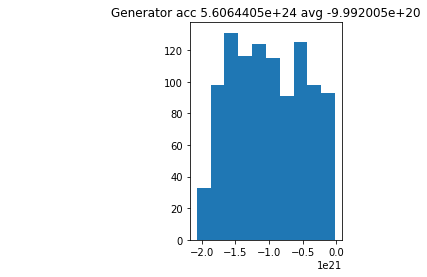

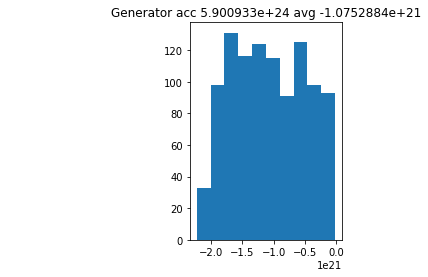

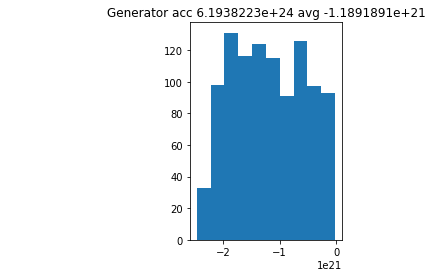

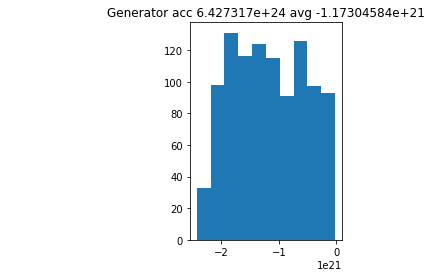

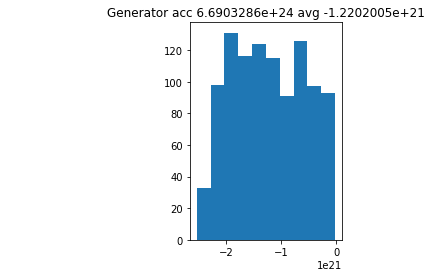

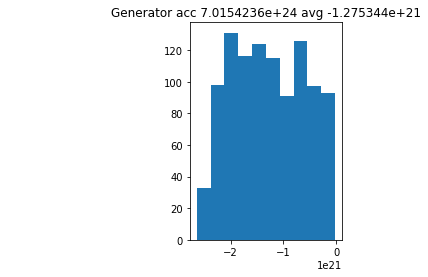

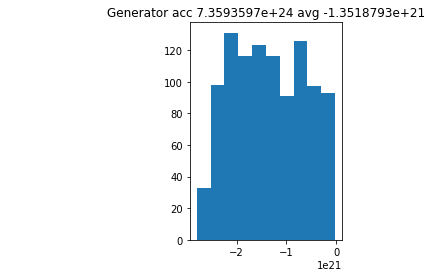

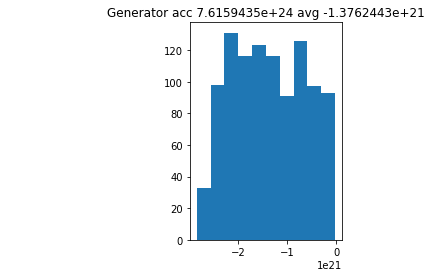

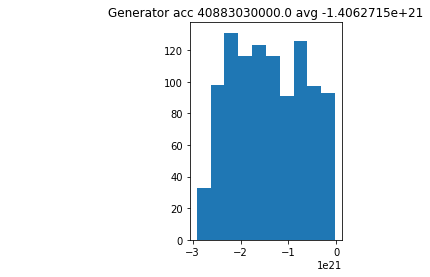

gen_acc 40883030000.0 after 5001
After Epoch 9 train_loss_gen: -6.836457e+24 train_loss_disc: 4.3679916e+24 running: 1211.3 sec ETA: 181.7 min
Epoch: __ 10
train_loss_disc: 6.3264256e+24 disc_acc: -1.0 after 1875


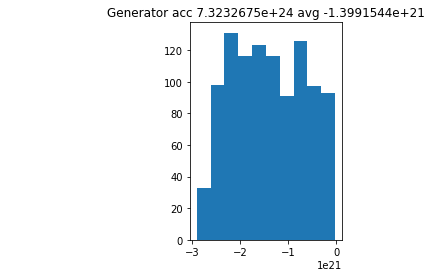

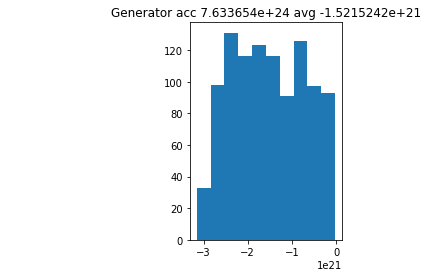

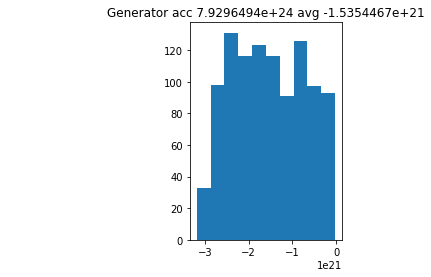

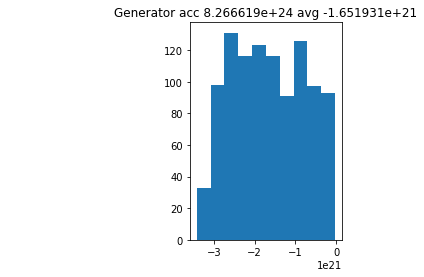

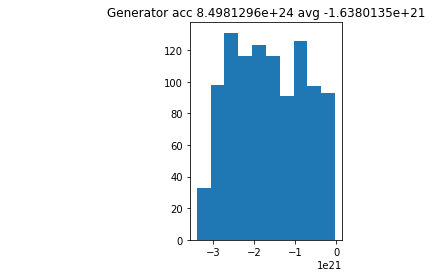

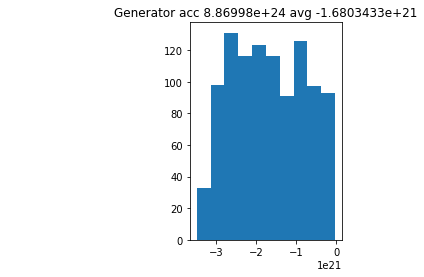

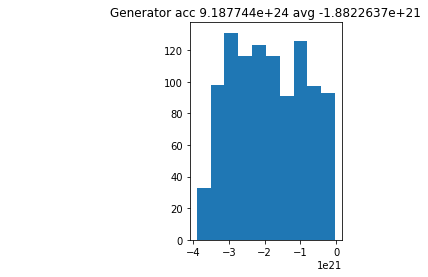

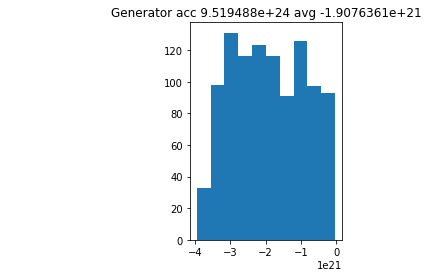

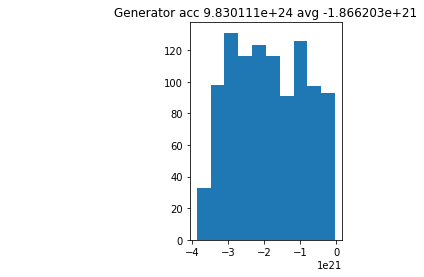

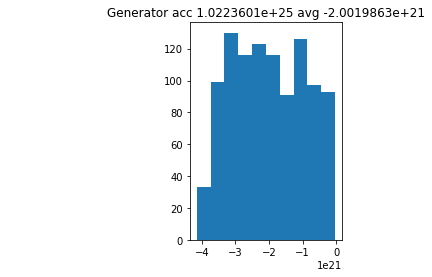

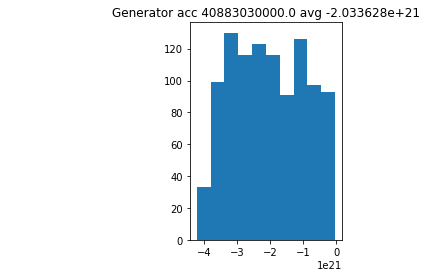

gen_acc 40883030000.0 after 5001
After Epoch 10 train_loss_gen: -9.11404e+24 train_loss_disc: 6.3264256e+24 running: 1459.2 sec ETA: 196.8 min
Epoch: __ 11
train_loss_disc: 8.4326097e+24 disc_acc: -1.0 after 1875


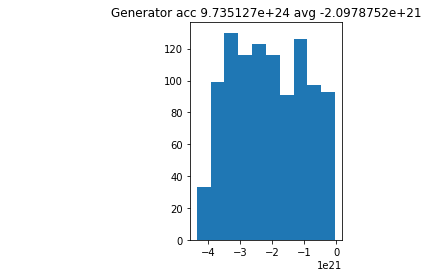

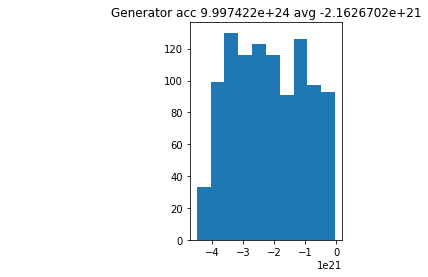

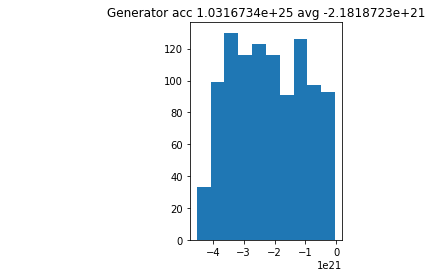

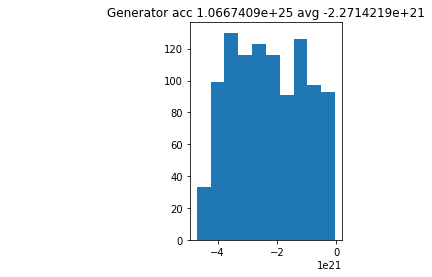

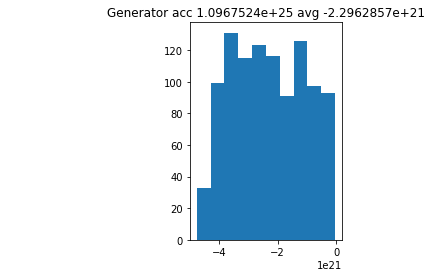

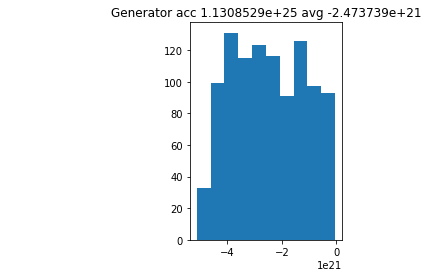

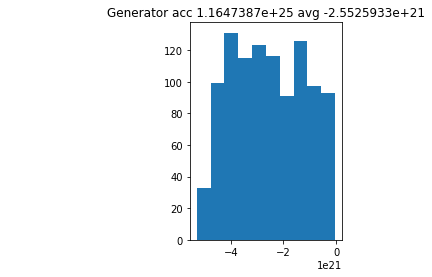

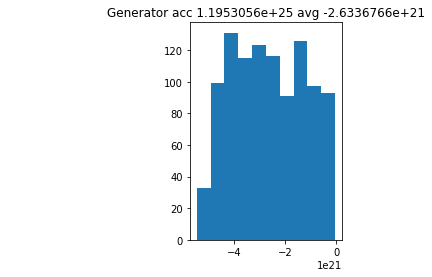

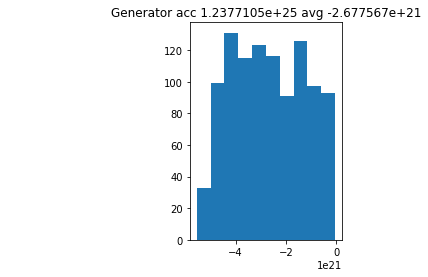

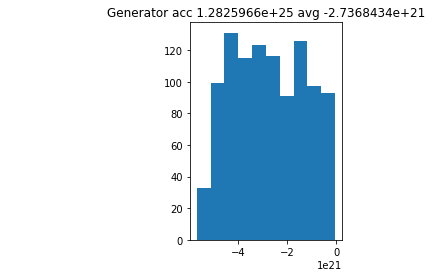

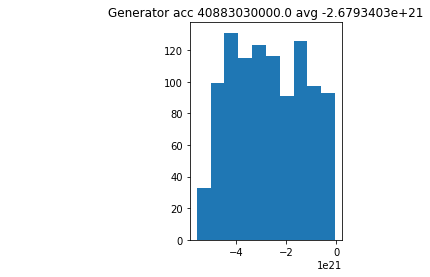

gen_acc 40883030000.0 after 5001
After Epoch 11 train_loss_gen: -1.14446e+25 train_loss_disc: 8.4326097e+24 running: 1707.0 sec ETA: 208.6 min
Epoch: __ 12
train_loss_disc: 1.0530007e+25 disc_acc: -1.0 after 1875


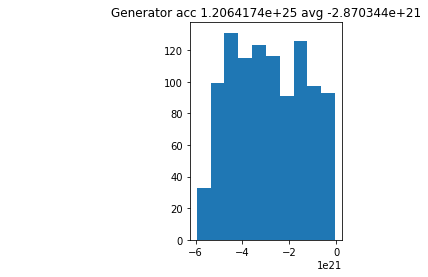

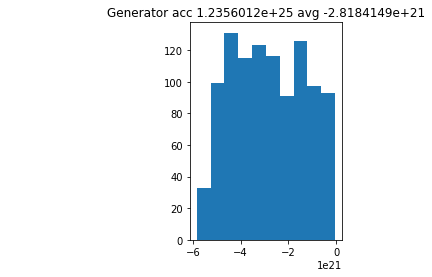

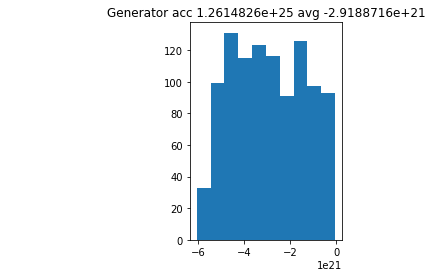

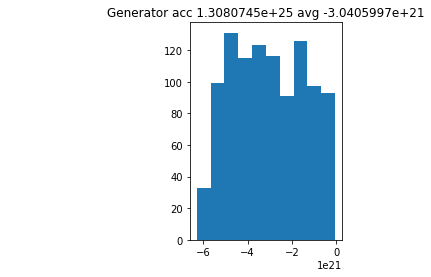

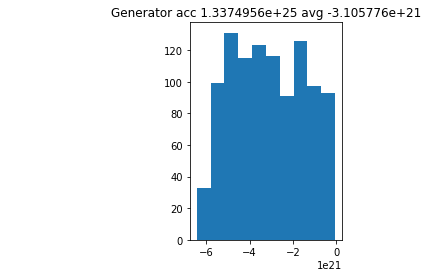

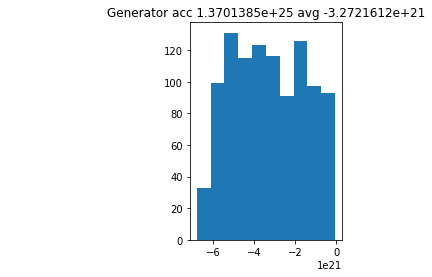

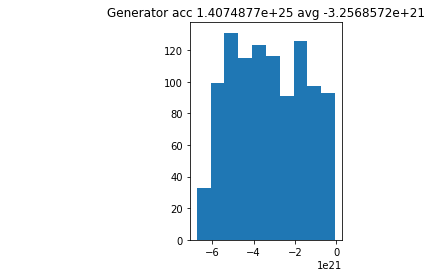

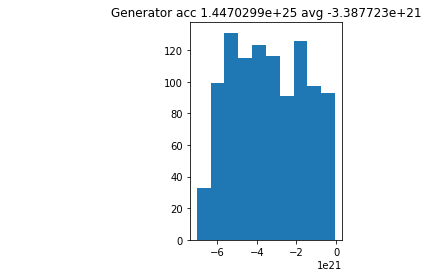

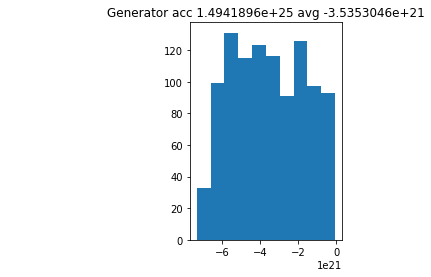

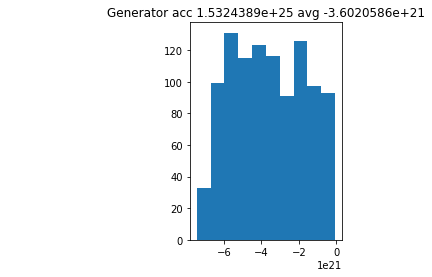

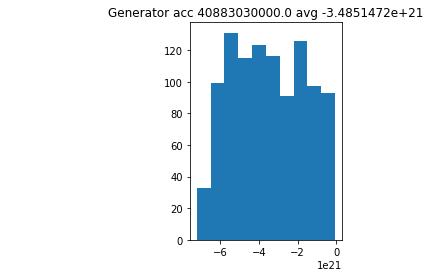

gen_acc 40883030000.0 after 5001
After Epoch 12 train_loss_gen: -1.3638721e+25 train_loss_disc: 1.0530007e+25 running: 1956.0 sec ETA: 218.2 min
Epoch: __ 13
train_loss_disc: 1.2572518e+25 disc_acc: -1.0 after 1875


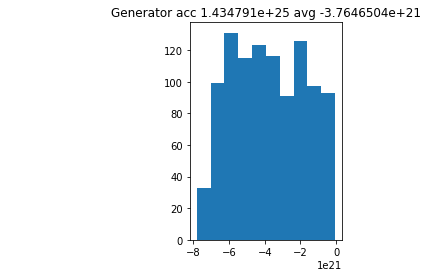

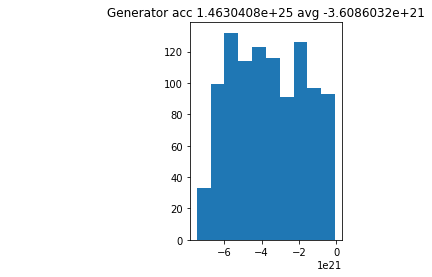

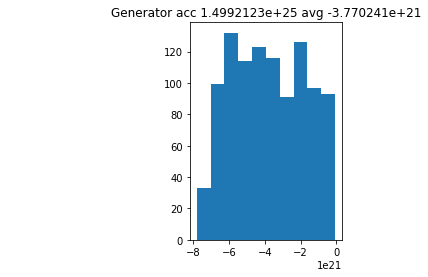

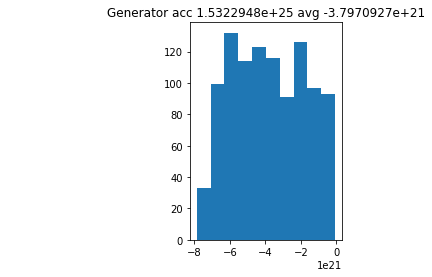

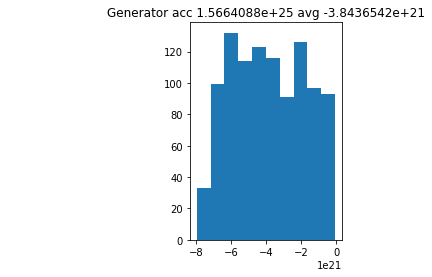

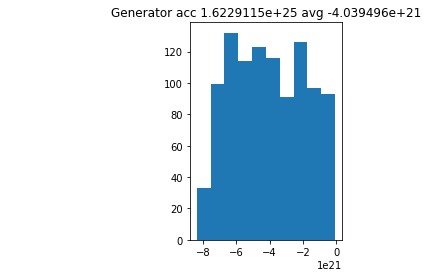

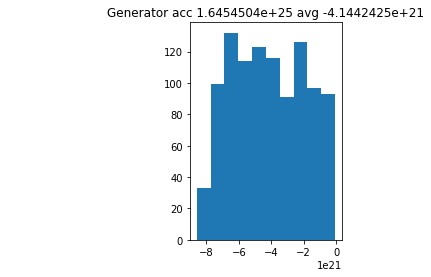

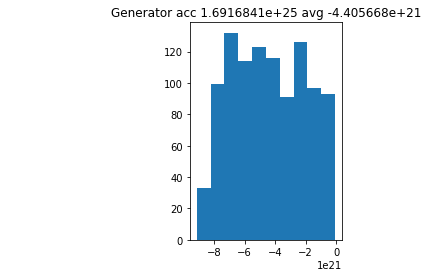

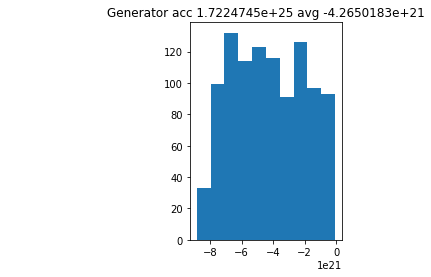

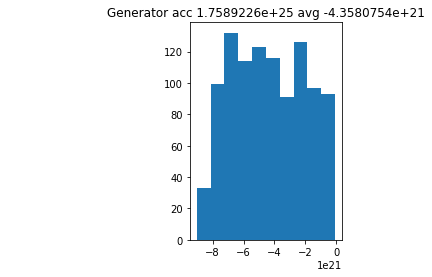

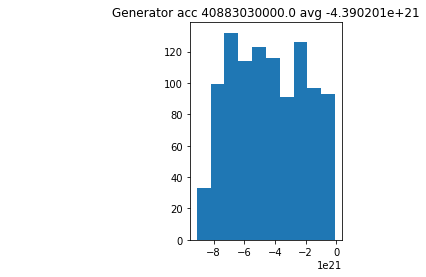

gen_acc 40883030000.0 after 5001
After Epoch 13 train_loss_gen: -1.5805181e+25 train_loss_disc: 1.2572518e+25 running: 2204.3 sec ETA: 225.7 min
Epoch: __ 14
train_loss_disc: 1.4562077e+25 disc_acc: -1.0 after 1875


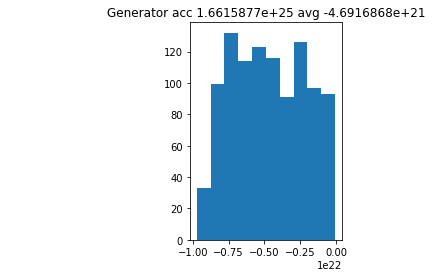

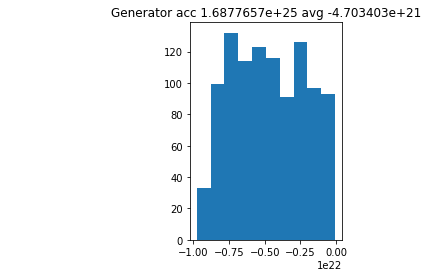

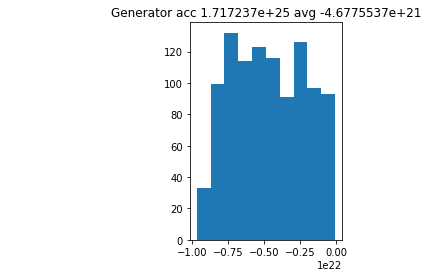

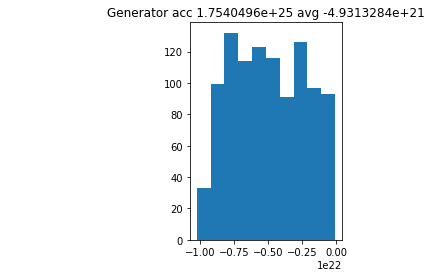

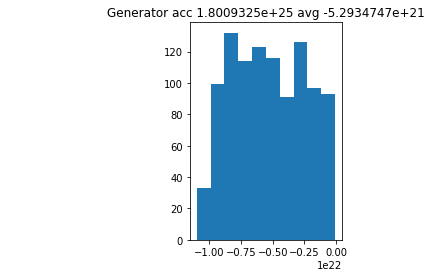

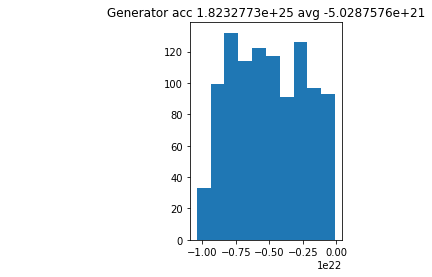

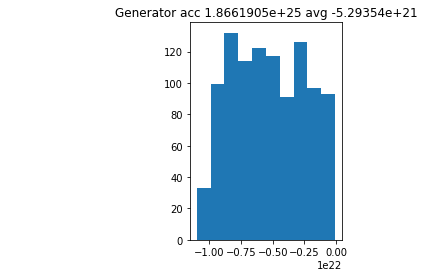

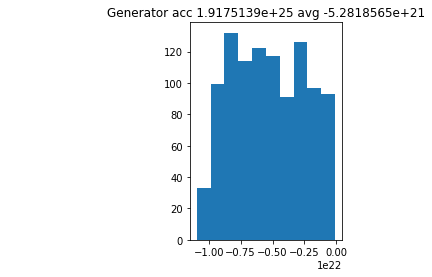

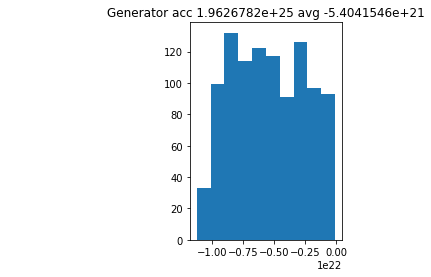

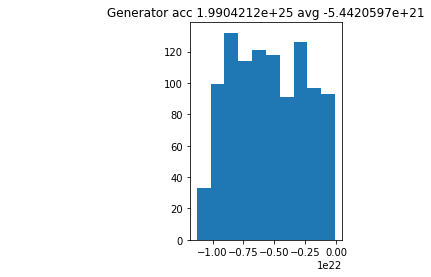

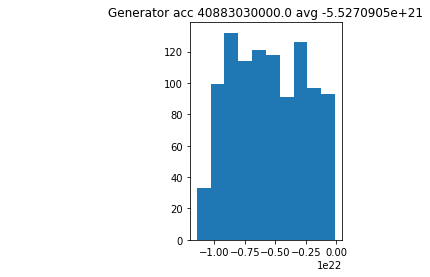

gen_acc 40883030000.0 after 5001
After Epoch 14 train_loss_gen: -1.7811776e+25 train_loss_disc: 1.4562077e+25 running: 2453.4 sec ETA: 231.7 min
Epoch: __ 15
train_loss_disc: 1.6297085e+25 disc_acc: -1.0 after 1875


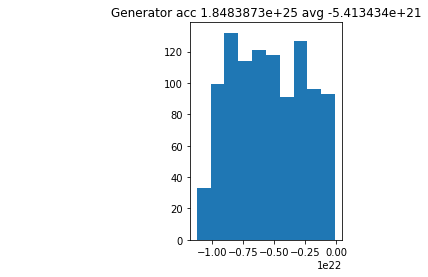

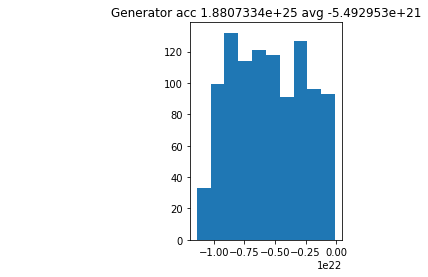

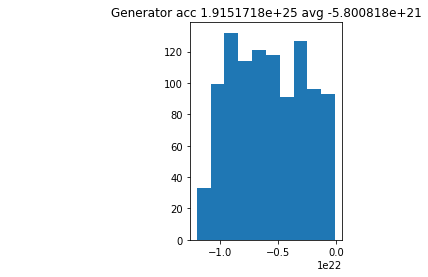

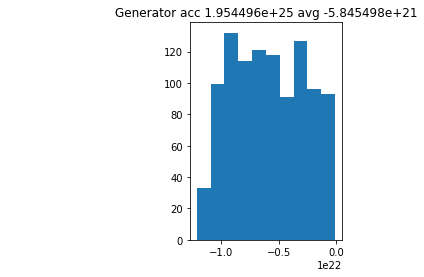

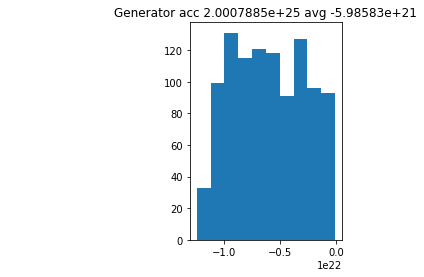

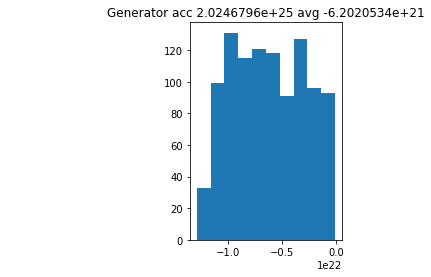

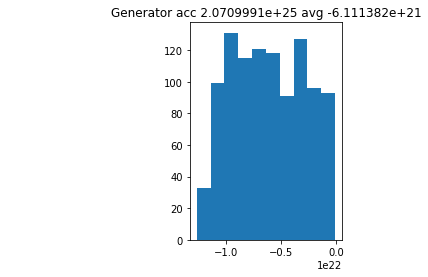

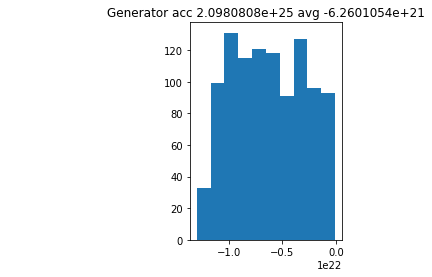

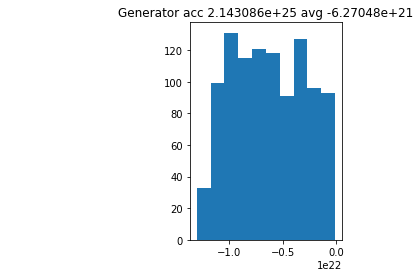

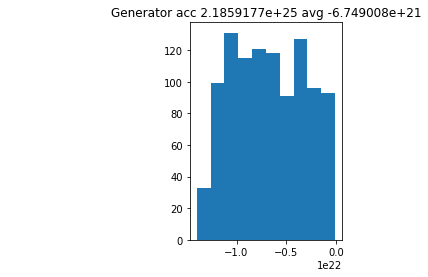

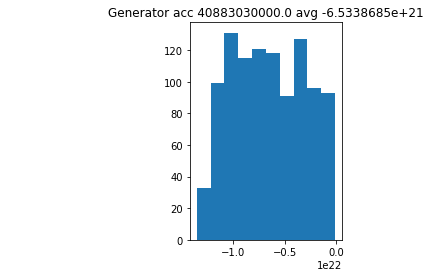

gen_acc 40883030000.0 after 5001
After Epoch 15 train_loss_gen: -1.9597855e+25 train_loss_disc: 1.6297085e+25 running: 2701.8 sec ETA: 236.4 min
Epoch: __ 16
train_loss_disc: 1.7894089e+25 disc_acc: -1.0 after 1875


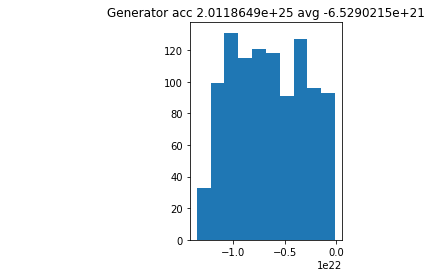

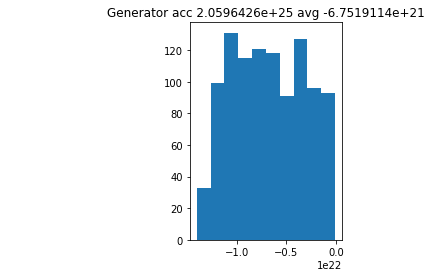

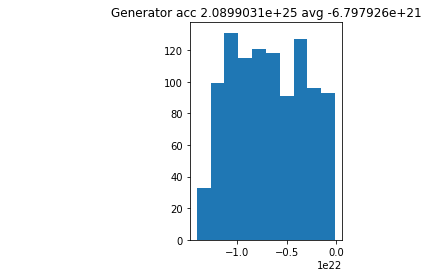

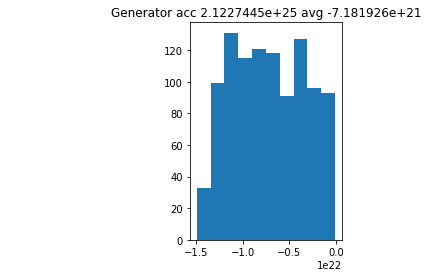

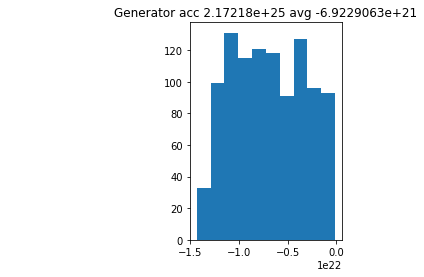

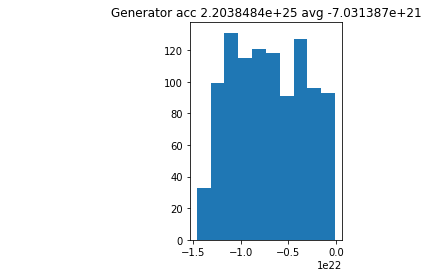

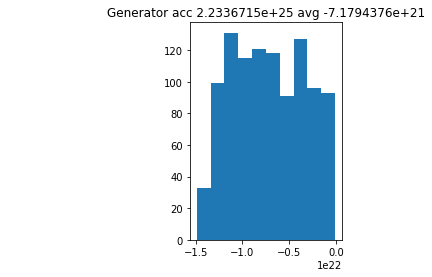

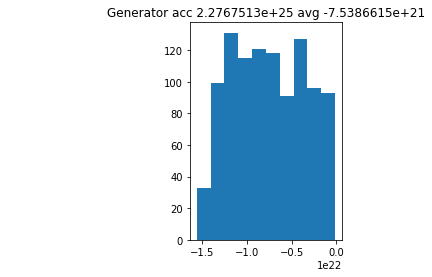

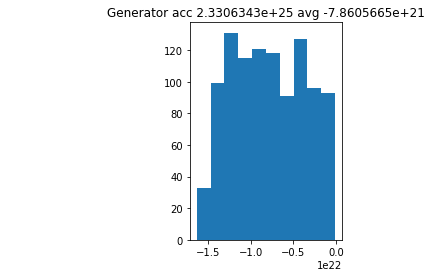

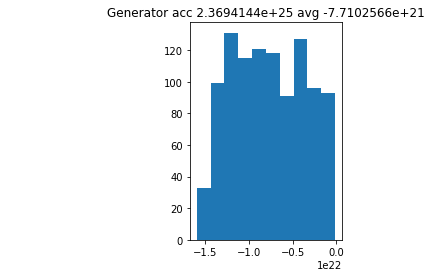

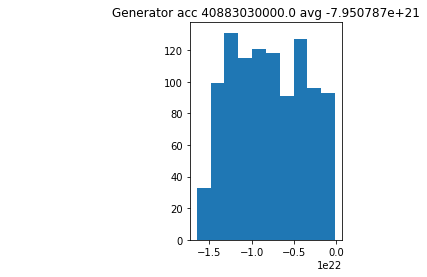

gen_acc 40883030000.0 after 5001
After Epoch 16 train_loss_gen: -2.1112947e+25 train_loss_disc: 1.7894089e+25 running: 2949.3 sec ETA: 240.0 min
Epoch: __ 17
train_loss_disc: 1.9259777e+25 disc_acc: -1.0 after 1875


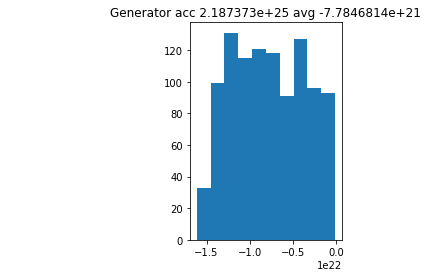

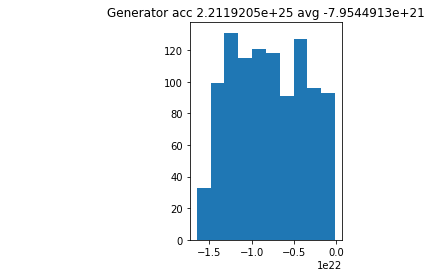

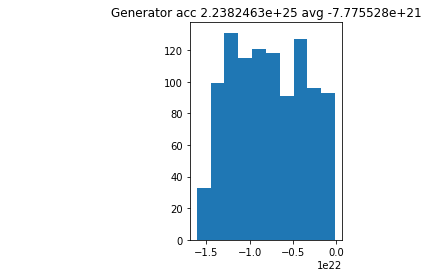

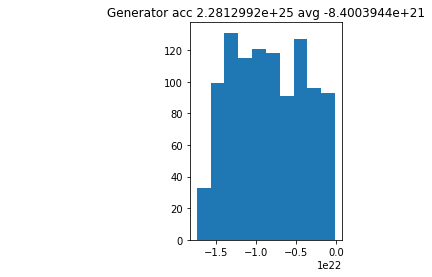

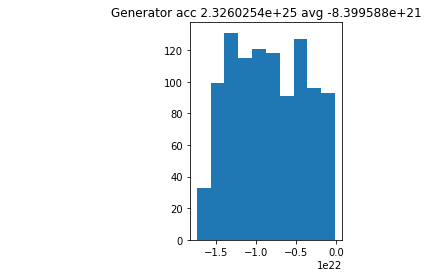

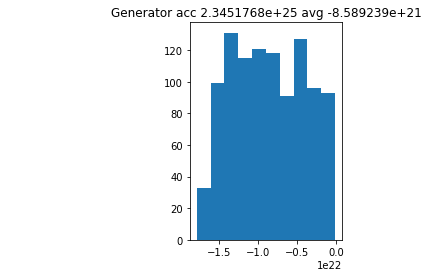

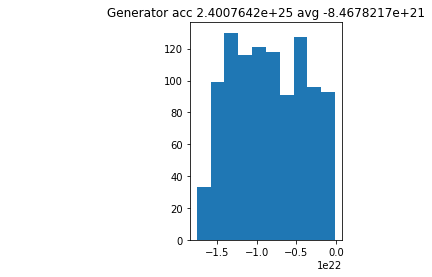

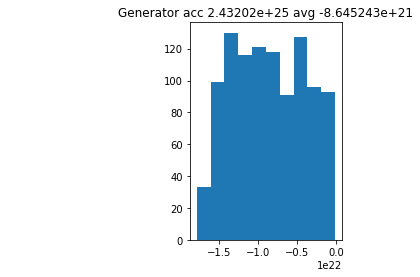

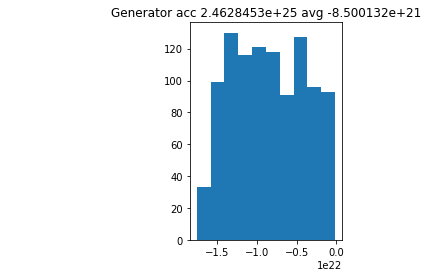

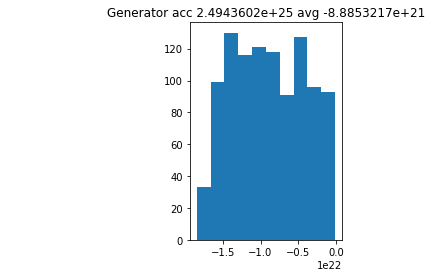

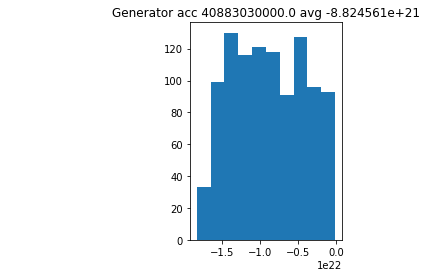

gen_acc 40883030000.0 after 5001
After Epoch 17 train_loss_gen: -2.2400462e+25 train_loss_disc: 1.9259777e+25 running: 3197.0 sec ETA: 242.7 min
Epoch: __ 18
train_loss_disc: 2.039455e+25 disc_acc: -1.0 after 1875


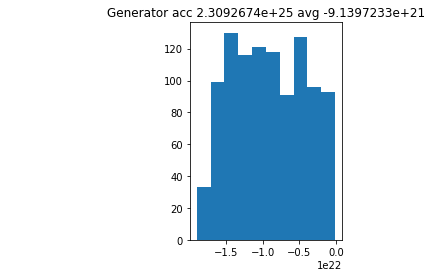

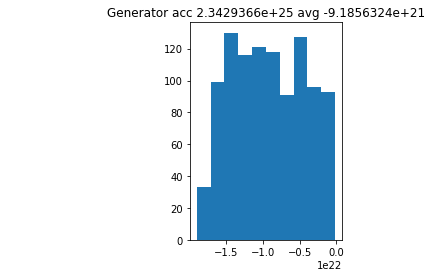

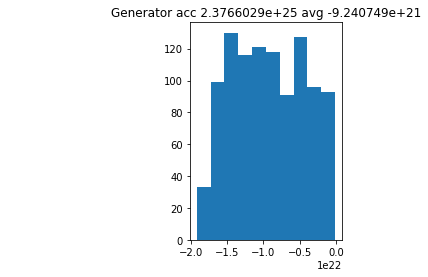

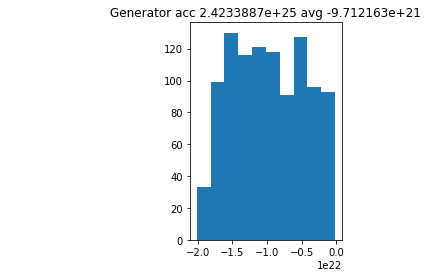

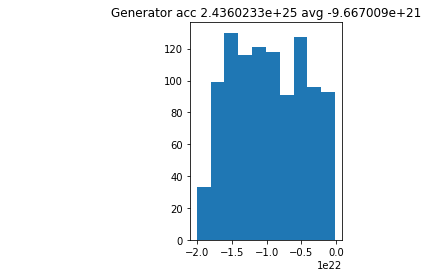

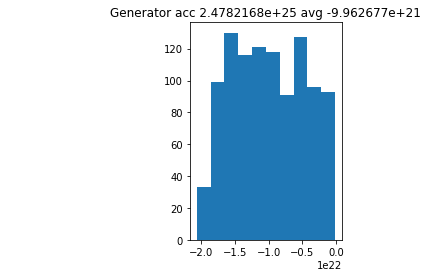

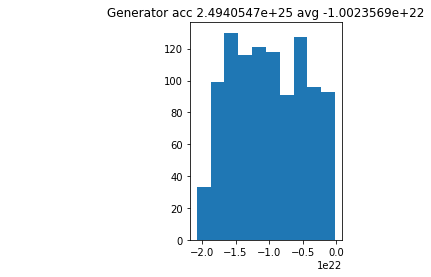

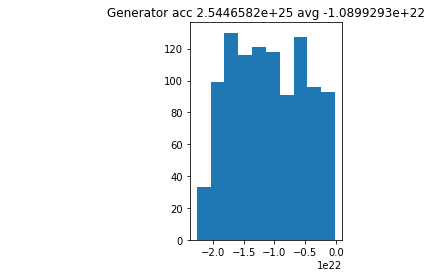

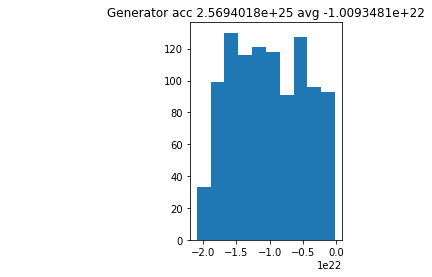

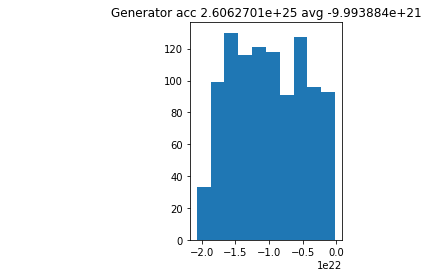

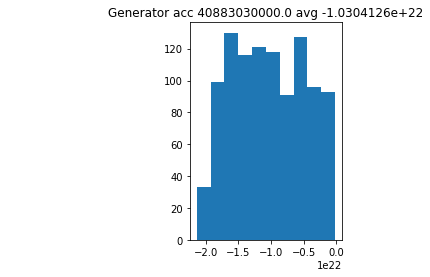

gen_acc 40883030000.0 after 5001
After Epoch 18 train_loss_gen: -2.3372719e+25 train_loss_disc: 2.039455e+25 running: 3444.1 sec ETA: 244.7 min
Epoch: __ 19
train_loss_disc: 2.1304495e+25 disc_acc: -1.0 after 1875


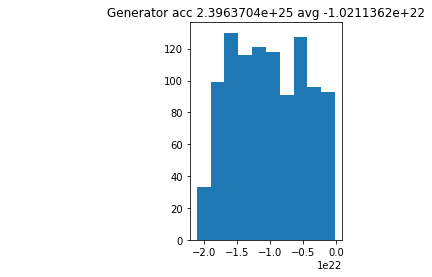

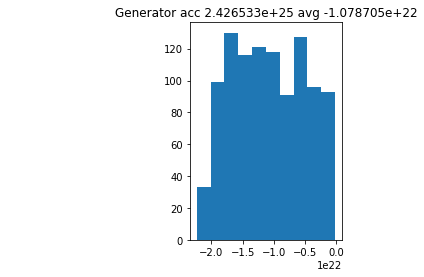

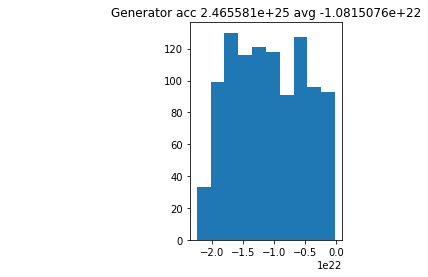

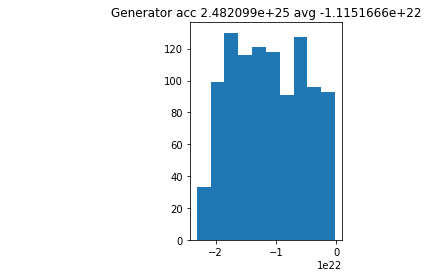

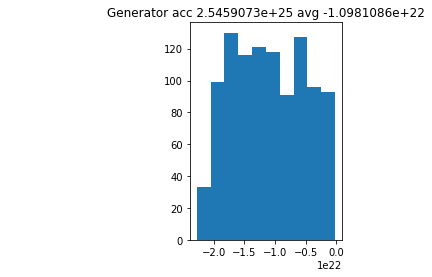

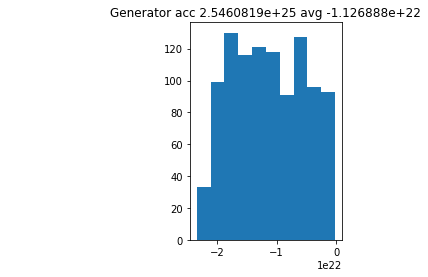

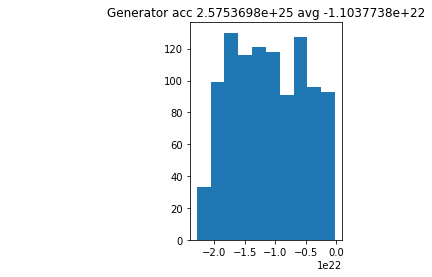

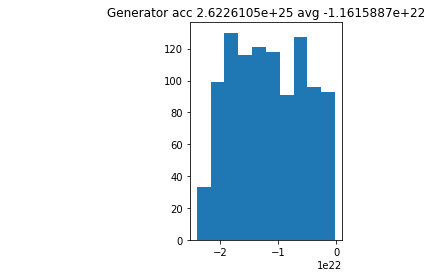

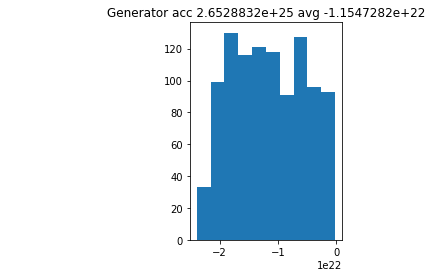

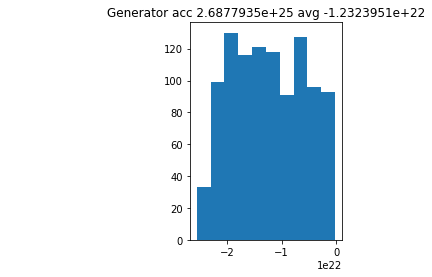

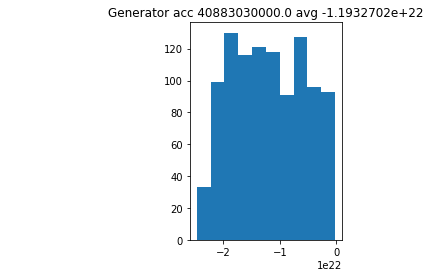

gen_acc 40883030000.0 after 5001
After Epoch 19 train_loss_gen: -2.411276e+25 train_loss_disc: 2.1304495e+25 running: 3690.5 sec ETA: 246.0 min
Epoch: __ 20
train_loss_disc: 2.1815064e+25 disc_acc: -1.0 after 1875


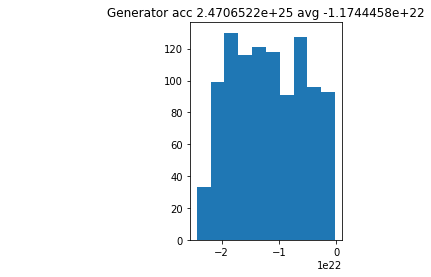

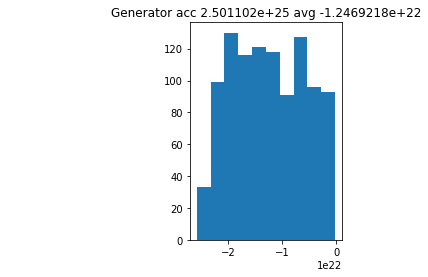

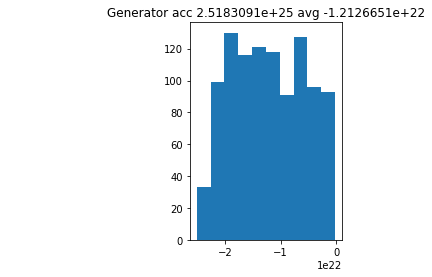

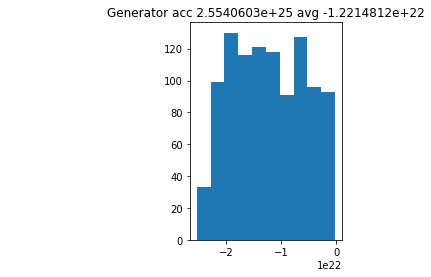

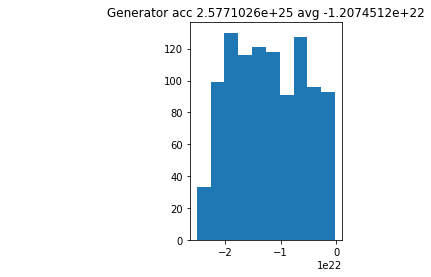

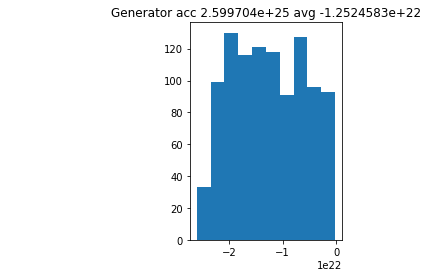

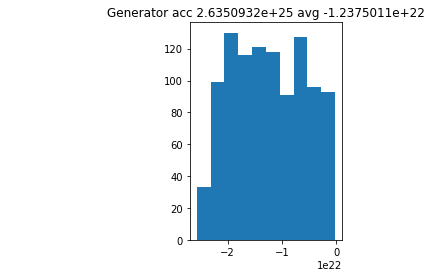

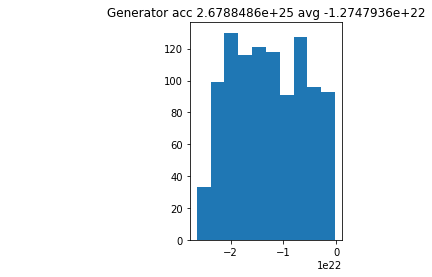

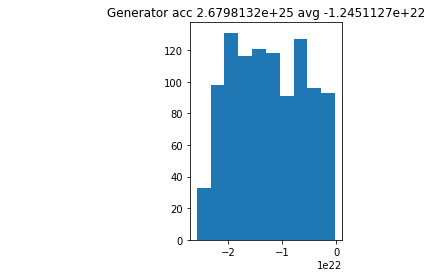

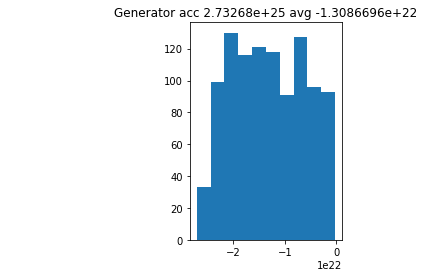

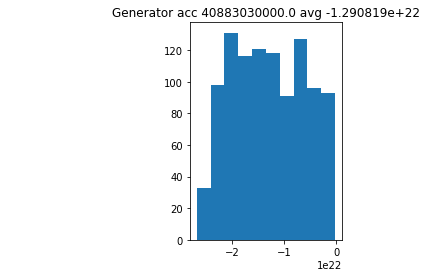

gen_acc 40883030000.0 after 5001
After Epoch 20 train_loss_gen: -2.4410565e+25 train_loss_disc: 2.1815064e+25 running: 3936.8 sec ETA: 246.8 min
Epoch: __ 21
train_loss_disc: 2.2023436e+25 disc_acc: -1.0 after 1875


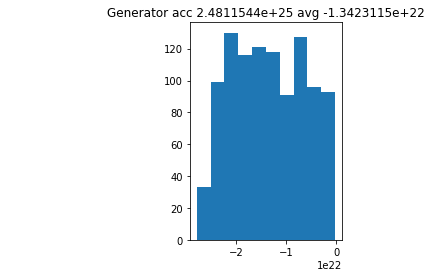

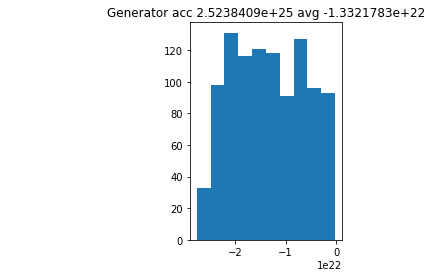

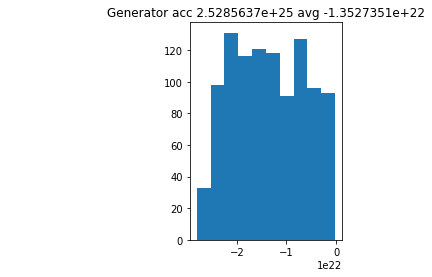

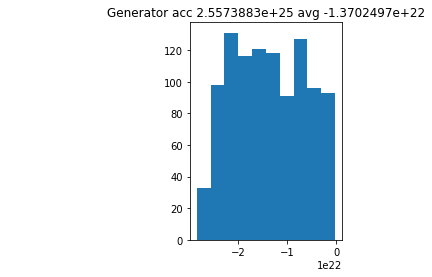

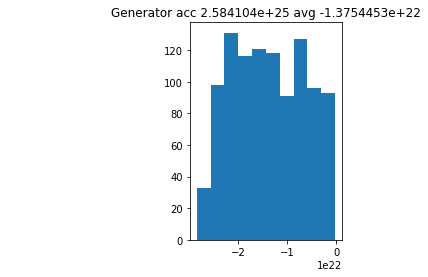

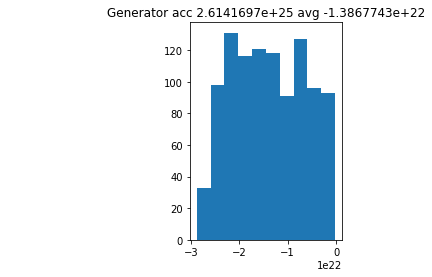

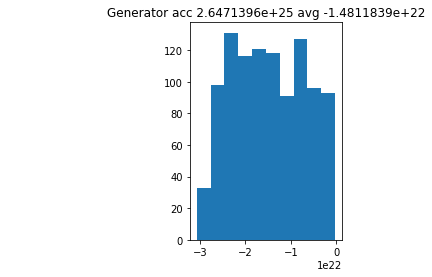

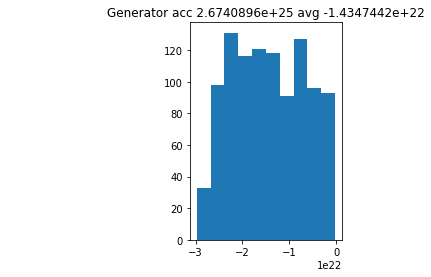

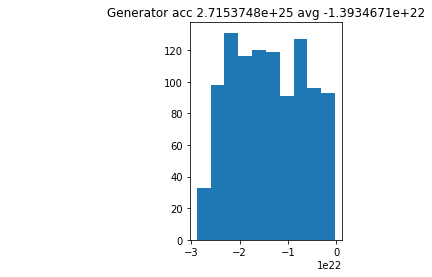

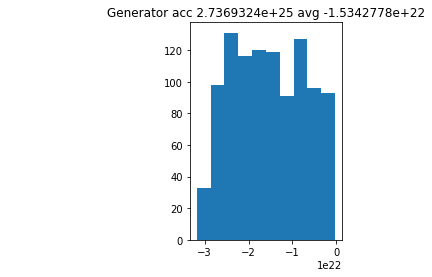

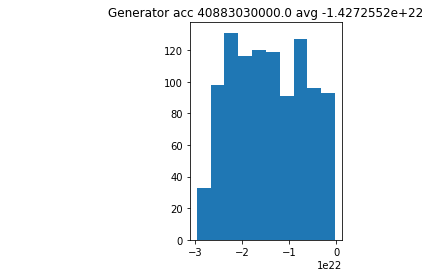

gen_acc 40883030000.0 after 5001
After Epoch 21 train_loss_gen: -2.4367858e+25 train_loss_disc: 2.2023436e+25 running: 4185.0 sec ETA: 247.3 min
Epoch: __ 22
train_loss_disc: 2.1986238e+25 disc_acc: -1.0 after 1875


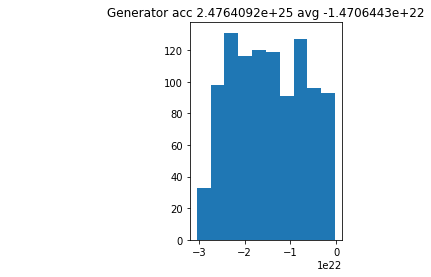

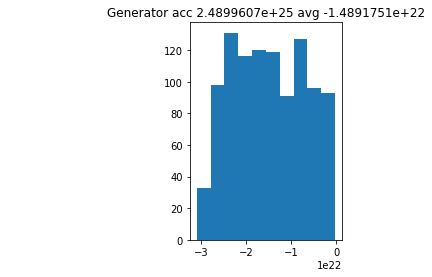

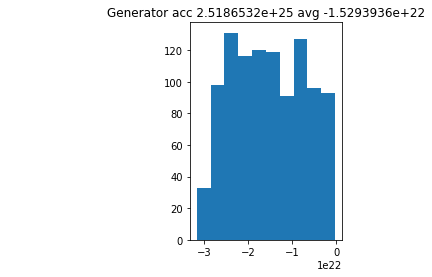

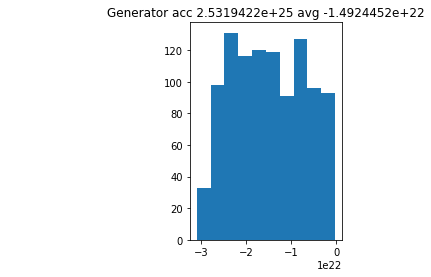

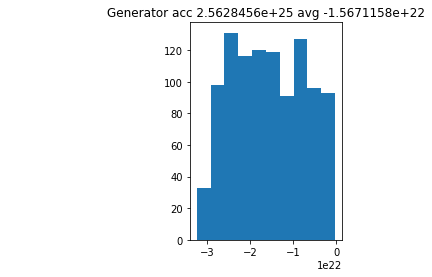

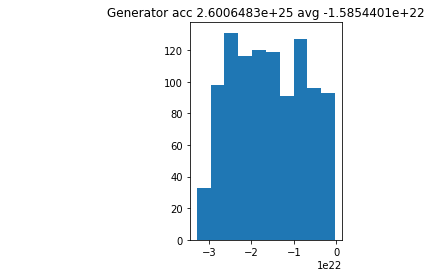

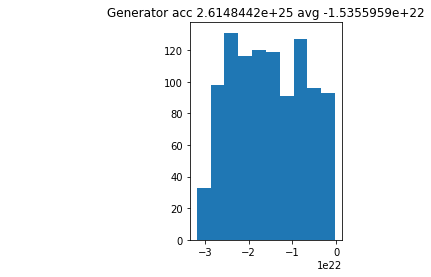

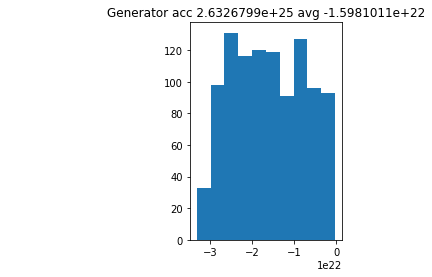

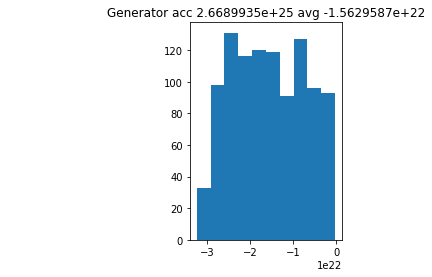

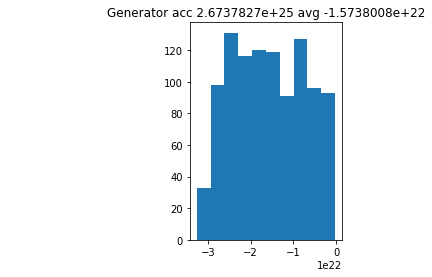

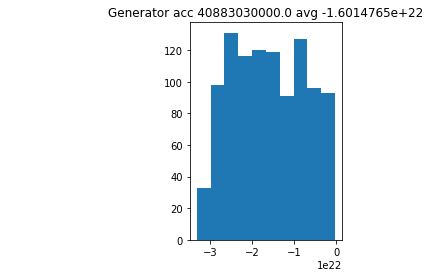

gen_acc 40883030000.0 after 5001
After Epoch 22 train_loss_gen: -2.4003337e+25 train_loss_disc: 2.1986238e+25 running: 4431.8 sec ETA: 247.3 min
Epoch: __ 23
train_loss_disc: 2.1598785e+25 disc_acc: -1.0 after 1875


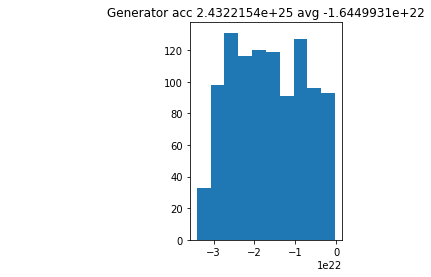

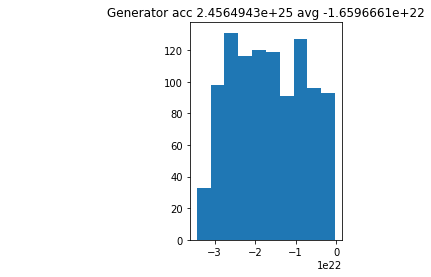

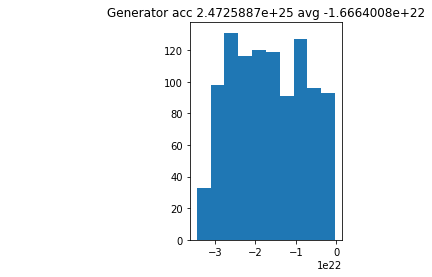

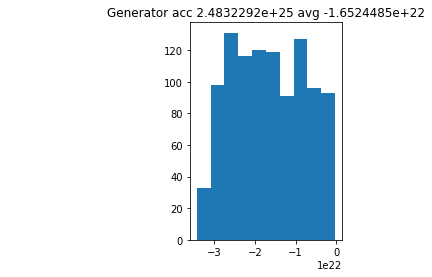

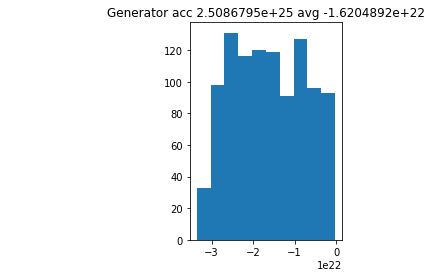

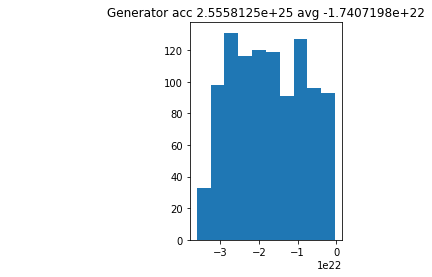

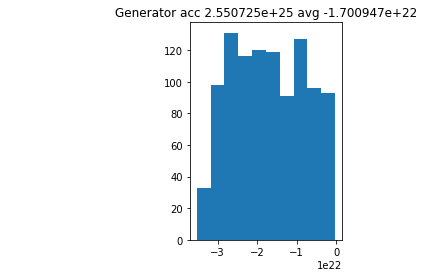

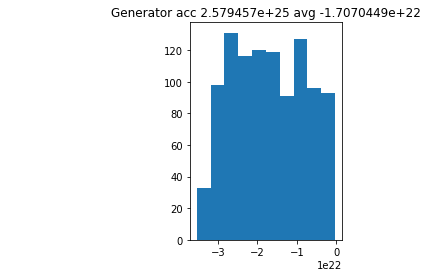

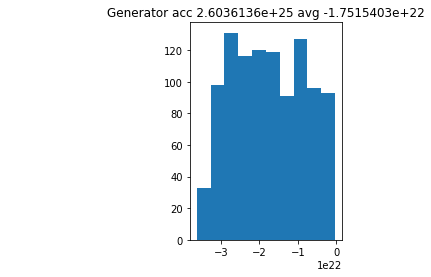

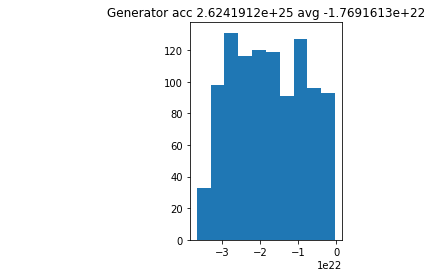

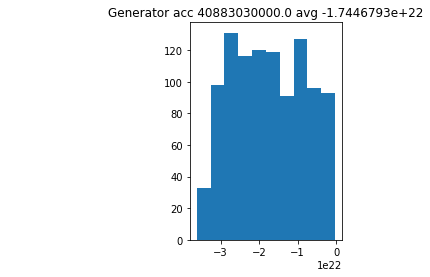

gen_acc 40883030000.0 after 5001
After Epoch 23 train_loss_gen: -2.3444555e+25 train_loss_disc: 2.1598785e+25 running: 4680.6 sec ETA: 247.0 min
Epoch: __ 24
train_loss_disc: 2.103797e+25 disc_acc: -1.0 after 1875


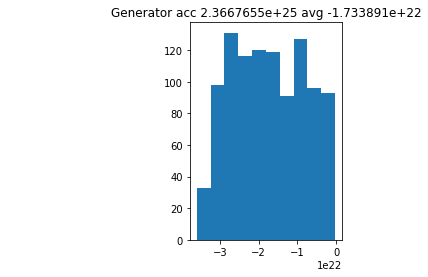

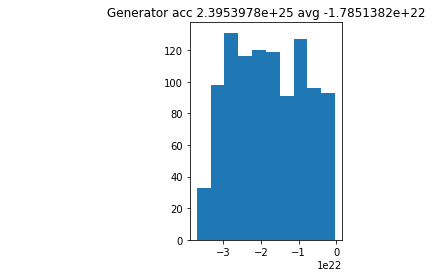

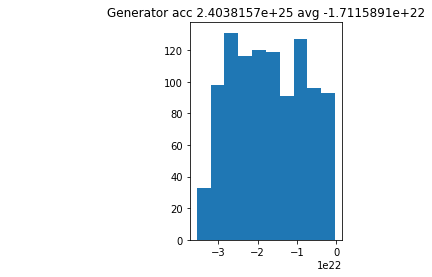

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 100
learning_rate = 0.0001
running_average_factor = 0.95

# Initialize the model.
#model = DenseNet(growth_rate=4, bottleneck=False)
#model = ResNet()
space_size = 100
generator = Generator(space_size)
discriminator = Discriminator()

# Using binary correntropy due to values between 0 and 1
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)

# Initialize lists for later visualization.
train_losses_gen = []
train_losses_disc = []
#test_losses = []
#test_accuracies = []

#testing once before we begin
#test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
#test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)
for data in train_ds:
  discriminator(data[0])
  break
print(discriminator.summary())
generator(random_input(32,space_size))
print(generator.summary())
#print("Pre-learning")
#print('test loss:', round(test_loss,4), 'acc:', round(test_accuracy,6))

#check how model performs on train data once before we begin
#train_loss, _ = test(model, train_ds, cross_entropy_loss)
#train_losses.append(train_loss)

# We train for num_epochs epochs.
time0 = time.time()
"""
running_average_disc = 0
#print(len(train_ds))

#pre train discriminator on empty image
count = 0 
while running_average_disc > 0.2 or count < 20:
    count+=1
    #print(input.shape)
    #break
      
    train_loss_disc = train_discriminator(generator,discriminator, space_size, input, cross_entropy_loss, optimizer, pre_train=True)
    running_average_disc = running_average_factor * running_average_disc  + (1 - running_average_factor) * train_loss_disc
print('Pretraining discriminator against blank images loss:', round(running_average_disc.numpy(),4))
"""
training_max = 20
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))
    #time1 = time.time()
    train_ds = train_ds.shuffle(buffer_size=32)
    #test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average_gen = 0
    running_average_disc = 0
    running_acc_gen = 0
    running_acc_disc = 0
    
    # train discriminator
    count = 0
    for (input,_) in train_ds:
        count+=1
        #print(input.shape)
        #break
         
        train_loss_disc, acc_disc = train_discriminator(generator,discriminator, space_size, input, cross_entropy_loss, optimizer)
        running_acc_disc = 0.95 * running_acc_disc + (1-0.95) * acc_disc
        running_average_disc = running_average_factor * running_average_disc  + (1 - running_average_factor) * train_loss_disc
        #if (count> 5 and running_acc_disc > 0.7 ):
        #  break
        if (count > training_max):
          training_max *= 2
          break
    print('train_loss_disc:', round(running_average_disc.numpy(),4), "disc_acc:",round(running_acc_disc.numpy(),4),"after",count)

    # train generator
    count = 0
    #for i in range(len(train_ds)):
    acc_gen = 0.0
    while True: #running_acc < 0.5:
        count+=1
        train_loss_gen, output_gen, acc_gen = train_generator(generator, discriminator, space_size, cross_entropy_loss, optimizer)
        running_acc_gen = 0.95 * running_acc_gen + (1-0.95) * acc_gen
        running_average_gen = running_average_factor * running_average_gen  + (1 - running_average_factor) * train_loss_gen
        if count%500 == 0: #(count > 20 and running_average_gen<0.05) or
          fig, ax = plt.subplots(1,2)
          ax[0].imshow(tf.clip_by_value(output_gen,-1,1)/2+0.5, cmap="gray_r")
          ax[0].axis('off')
          ax[1].hist(tf.reshape(output_gen,(1,-1)))
          plt.title("Generator acc "+str(round(running_acc_gen.numpy(),4))+" avg "+str(tf.reduce_mean(output_gen).numpy()))
          plt.show()
          #first=False
          #if running_average_gen < 0.05:
          #  break
        #print("count",count,"training_max",training_max)
        if count > training_max*2 or count > 5000:
          break
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(tf.clip_by_value(output_gen,-1,1), cmap="gray_r")
    ax[0].axis('off')
    ax[1].hist(tf.reshape(output_gen,(1,-1)))
    plt.title("Generator acc "+str(round(running_acc.numpy(),4))+" avg "+str(tf.reduce_mean(output_gen).numpy()))
    plt.show()
    print("gen_acc",round(running_acc.numpy(),4),"after",count)
    train_losses_gen.append(running_average_gen)
    train_losses_disc.append(running_average_disc)
    #print(running_average_gen,running_average_disc)


    #testing
    #test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    #test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)
    run_time = time.time()-time0 
    print("After Epoch",epoch,'train_loss_gen:', round(running_average_gen.numpy(),4), 'train_loss_disc:', round(running_average_disc.numpy(),4), "running:",round(run_time,1),"sec ETA:",round(((run_time)/(epoch+1)*num_epochs-run_time)/60,1),"min")



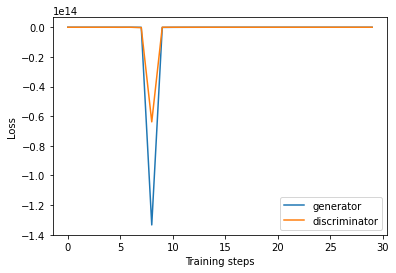

In [102]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses_gen,label="generator")
line2, = plt.plot(train_losses_disc,label="discriminator")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()
